## I.Data Wrangling and Exploration

In [3]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree
import numpy as np
import seaborn as sns
from matplotlib.gridspec import GridSpec
from geographiclib.geodesic import Geodesic
from sklearn.ensemble import RandomForestRegressor
import warnings

### 1. Load Data

In [5]:
warnings.filterwarnings('ignore')
#Load Data Files
## LTE Coverage Metrics## RF Signal Quality Features
RSRP = pd.read_excel('C:/Users/obouk/OneDrive/Bureau/Project Data/Needed/Code/RSRP.xlsx')
SINR = pd.read_excel('C:/Users/obouk/OneDrive/Bureau/Project Data/Needed/Code/SINR.xlsx')
RSRQ = pd.read_excel('C:/Users/obouk/OneDrive/Bureau/Project Data/Needed/Code/RSRQ.xlsx')

## Geagraphical Data
Zone_Classification = pd.read_csv('C:/Users/obouk/OneDrive/Bureau/Project Data/Needed/Code/constantine_zone_classification.csv')

##Cell Tower Data
EPT = pd.read_excel('C:/Users/obouk/OneDrive/Bureau/Project Data/Needed/Code/EPT.xlsx', sheet_name= '4G')

## Cells KPIs Data
KPIs = pd.read_excel('C:/Users/obouk/OneDrive/Bureau/Project Data/Needed/Code/KPI Analysis Result.xlsx')

### 2. Data Exploration and Cleaning

#### 2.1 Data preparation and cleanup of datasets  related to LTE radio signal metrics.

In [8]:
# Display first few rows of each dataset
display(RSRP.sample(5),RSRQ.sample(5),SINR.sample(5))

,Unnamed: 0,Time,Date,Latitude,Longitude,Serving Cell RSRP (dBm)
14322,NaN,15:53:41.000,2/23/2020,36.365818,6.638560,-90.300003
10036,NaN,10:24:55.000,2/23/2020,36.346324,6.626061,-84.900002
2985,NaN,15:01:51.000,2/21/2020,36.354722,6.650269,-87.699997
29312,NaN,11:03:03.000,2/26/2020,36.323887,6.582060,-95.199997
23682,NaN,11:09:59.000,2/25/2020,36.341305,6.603645,-71.400002


,Unnamed: 0,Time,Date,Latitude,Longitude,Serving Cell RSRQ (dB)
5994,NaN,09:28:39.000,2/22/2020,36.415583,6.660405,-12.2
349,NaN,10:12:43.000,2/21/2020,36.325837,6.663175,-11.8
701,NaN,10:34:41.000,2/21/2020,36.330299,6.659904,-11.3
22016,NaN,17:37:51.000,2/24/2020,36.360112,6.601527,-10.9
7602,NaN,12:13:21.000,2/22/2020,36.377129,6.635192,-9.9


,Unnamed: 0,Time,Date,Latitude,Longitude,Serving Cell RS SINR (dB)
6756,NaN,11:12:57.000,2/22/2020,36.389967,6.642576,-3.0
16784,NaN,10:36:35.000,2/24/2020,36.357035,6.616417,1.6
23820,NaN,11:21:33.000,2/25/2020,36.348517,6.620655,-7.5
16694,NaN,10:30:41.000,2/24/2020,36.360978,6.616343,-5.9
19298,NaN,14:07:49.000,2/24/2020,36.373615,6.618908,-0.9


##### The first columns of each datasets look similar and can be merged into one DataFrame. The column "Unnamed: 0" appears to not contain any meaningful values. Furthermore, we need to check the data type for each column and the number of null values in each one of them.

In [10]:
# Display datset structure and data types
display(RSRP.info(), RSRQ.info(), SINR.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33528 entries, 0 to 33527
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               0 non-null      float64
 1   Time                     33528 non-null  object 
 2   Date                     33528 non-null  object 
 3   Latitude                 33526 non-null  float64
 4   Longitude                33526 non-null  float64
 5   Serving Cell RSRP (dBm)  33528 non-null  float64
dtypes: float64(4), object(2)
memory usage: 1.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33526 entries, 0 to 33525
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              0 non-null      float64
 1   Time                    33526 non-null  object 
 2   Date                    33526 non-null  object 
 3   Latitude                33524 

None

None

None

In [11]:
display(RSRP['Unnamed: 0'].unique(),RSRQ['Unnamed: 0'].unique(),SINR['Unnamed: 0'].unique())

array([nan])

array([nan])

array([nan])

##### The rows counts are slightly different, which should be considered during the join, also 'Unnamed: 0' column indeed has no values in all rows and should be removed. Furthermore, the 'Date' and 'Time' columns are likely stored as strings and should be converted to a datetime type

In [13]:
#Removing Unnamed: 0 column for all datasets
SINR = SINR.drop(columns=['Unnamed: 0'])
RSRP = RSRP.drop(columns=['Unnamed: 0'])
RSRQ = RSRQ.drop(columns=['Unnamed: 0'])

##### Next, we need to merge 3 datasets of LTE radio signal metrics into one dataframe using commun columns Time, Data, Longitude and Latitude

In [15]:
dfMerge = pd.merge(RSRP, RSRQ, on = ['Time', 'Date','Latitude', 'Longitude'], how = 'outer')

In [16]:
Cov_Metrics = pd.merge(dfMerge,SINR, on = ['Time', 'Date','Latitude', 'Longitude'], how = 'outer')

##### Convert Date and Time columns from string to DateTime type

In [18]:
Cov_Metrics['Date Time'] = pd.to_datetime(Cov_Metrics['Date']+' '+ Cov_Metrics['Time'])

In [19]:
Cov_Metrics.insert(0, 'Date Time', Cov_Metrics.pop('Date Time'))

In [20]:
Cov_Metrics = Cov_Metrics.drop(columns=['Date', 'Time'])

In [21]:
Cov_Metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33528 entries, 0 to 33527
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date Time                  33528 non-null  datetime64[ns]
 1   Latitude                   33526 non-null  float64       
 2   Longitude                  33526 non-null  float64       
 3   Serving Cell RSRP (dBm)    33528 non-null  float64       
 4   Serving Cell RSRQ (dB)     33526 non-null  float64       
 5   Serving Cell RS SINR (dB)  33500 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.5 MB


##### The 'Date' and 'Time' columns have been unified and converted into datetime data type.

In [23]:
#Checking for missing values in each column
Cov_Metrics.isnull().sum()

Date Time                     0
Latitude                      2
Longitude                     2
Serving Cell RSRP (dBm)       0
Serving Cell RSRQ (dB)        2
Serving Cell RS SINR (dB)    28
dtype: int64

##### Some of features has missing values need to be deleted or estimated, in this case will just drop them all since we dont have a lot of rows with missing values

In [25]:
#Removing all null values
Cov_Metrics = Cov_Metrics.dropna()


In [26]:
#Checking if null values have been removed
Cov_Metrics.isnull().sum()

Date Time                    0
Latitude                     0
Longitude                    0
Serving Cell RSRP (dBm)      0
Serving Cell RSRQ (dB)       0
Serving Cell RS SINR (dB)    0
dtype: int64

In [27]:
Cov_Metrics.sample(10)

,Date Time,Latitude,Longitude,Serving Cell RSRP (dBm),Serving Cell RSRQ (dB),Serving Cell RS SINR (dB)
26112,2020-02-22 15:39:45,36.371473,6.640297,-93.599998,-17.299999,-4.9
24872,2020-02-26 15:23:25,36.311963,6.631899,-81.000000,-10.100000,10.5
8924,2020-02-24 11:23:37,36.360947,6.607926,-77.099998,-11.600000,4.4
9205,2020-02-25 11:27:17,36.349724,6.608112,-73.699997,-14.900000,-2.4
13281,2020-02-25 12:19:31,36.357935,6.594100,-89.699997,-18.900000,-5.8
3955,2020-02-26 10:28:33,36.330325,6.571488,-105.800003,-18.500000,-6.7
29591,2020-02-21 16:37:15,36.351724,6.649350,-72.500000,-10.300000,12.7
28225,2020-02-25 16:13:57,36.348397,6.588907,-90.500000,-17.200001,-4.6
18890,2020-02-22 13:42:27,36.380043,6.646880,-90.900002,-14.100000,-3.9
8383,2020-02-25 11:17:57,36.349721,6.607463,-78.300003,-14.500000,-0.1


In [28]:
Cov_Metrics.head()

,Date Time,Latitude,Longitude,Serving Cell RSRP (dBm),Serving Cell RSRQ (dB),Serving Cell RS SINR (dB)
0,2020-02-22 09:06:25,36.347757,6.693583,-95.900002,-13.7,9.4
1,2020-02-22 09:06:27,36.347757,6.693583,-95.400002,-11.5,14.1
2,2020-02-22 09:06:29,36.347757,6.693583,-94.800003,-23.1,-8.6
3,2020-02-22 09:06:59,36.347757,6.693583,-91.300003,-18.4,-2.8
4,2020-02-22 09:07:01,36.347757,6.693583,-95.199997,-23.0,-10.5


In [29]:
#Checking number of duplicates rows regarding of Latitude and Longitude Columns
Cov_Metrics.duplicated(subset = ['Latitude','Longitude']).sum()

5084

##### The new dataset, obtained by cleaning and merging three different datasets containing LTE radio signal metrics,has an appropriate data type structre for each column and contains no-null values withihn the DataFrame. After observation, it appears that the columns may need to be standardised in the future, there're also some redundancy in term of longitude and latitude(5084 rows)that need to be removed.

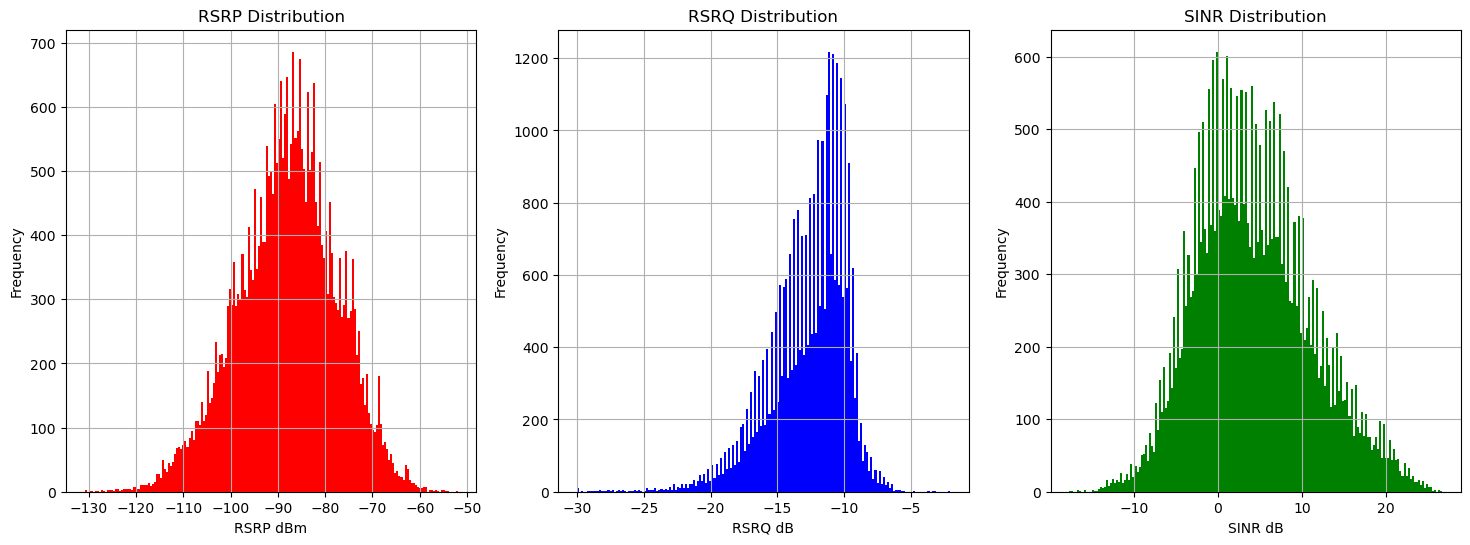

In [31]:
plt.figure(figsize=(18, 6))

plt.subplot(1,3,1)
Cov_Metrics['Serving Cell RSRP (dBm)'].hist(bins=183, color = 'red')
plt.title('RSRP Distribution')
plt.ylabel('Frequency')
plt.xlabel('RSRP dBm')

plt.subplot(1,3,2)
Cov_Metrics['Serving Cell RSRQ (dB)'].hist(bins=183, color = 'blue')
plt.title('RSRQ Distribution')
plt.ylabel('Frequency')
plt.xlabel('RSRQ dB')


plt.subplot(1,3,3)
Cov_Metrics['Serving Cell RS SINR (dB)'].hist(bins=183, color = 'green')
plt.title('SINR Distribution')
plt.ylabel('Frequency')
plt.xlabel('SINR dB')

plt.savefig('Quality Signal Metrics Distributions.png')

plt.show()

In [32]:
df = pd.DataFrame({
'RSRP (dBm)': Cov_Metrics['Serving Cell RSRP (dBm)'].describe(),
'RSRQ (dB)': Cov_Metrics['Serving Cell RSRQ (dB)'].describe(),
'SINR (dB)': Cov_Metrics['Serving Cell RS SINR (dB)'].describe()})
df

,RSRP (dBm),RSRQ (dB),SINR (dB)
count,33496.000000,33496.000000,33496.000000
mean,-87.968023,-12.701227,4.279699
std,10.433562,2.875281,6.842216
min,-130.899994,-30.000000,-17.700001
25%,-94.800003,-14.400000,-0.700000
50%,-87.599998,-12.100000,3.600000
75%,-80.900002,-10.600000,8.600000
max,-52.000000,-2.100000,26.700001


##### The mean~median are both likely in modal interval for RSRP values, observing its figure showing their distribution that the values  are Symmetric and Normally ditrubted.
##### Regarding RSRQ distribution, the histogram is negatively skewed  'mean < median' .
##### SINR values distribution are slightly skewed to the left (positive skewed mean > median).

##### Note: We could replace missing values in a numerical column by
##### •column mean might be good compromise if variable has symmetric distribution
##### •column median might be good compromise if variable has skewed distribution

##### For all duplicated GPS cordinates values, we'll leave only a unique value assigning to each one of them an average values(mean or median, depends on their distribution form) of other features RSRP, RSRQ and SINR.

In [35]:
Cov_Metrics = Cov_Metrics.groupby(['Latitude','Longitude'], as_index=False).agg({
    'Date Time': 'first',
    'Serving Cell RSRP (dBm)': 'mean',
    'Serving Cell RSRQ (dB)': 'median',
    'Serving Cell RS SINR (dB)': 'median',
})

In [36]:
#Checking redenduncy for GPS positions
Cov_Metrics.duplicated(subset = ['Latitude','Longitude']).sum()

0

In [37]:
display(
Cov_Metrics['Serving Cell RSRP (dBm)'].describe(),
Cov_Metrics['Serving Cell RSRQ (dB)'].describe(),
Cov_Metrics['Serving Cell RS SINR (dB)'].describe())

count    28412.000000
mean       -88.103560
std         10.564447
min       -130.899994
25%        -95.000000
50%        -87.800003
75%        -80.800003
max        -52.000000
Name: Serving Cell RSRP (dBm), dtype: float64

count    28412.000000
mean       -12.735038
std          2.964649
min        -30.000000
25%        -14.400000
50%        -12.100000
75%        -10.500000
max         -3.200000
Name: Serving Cell RSRQ (dB), dtype: float64

count    28412.000000
mean         4.266878
std          6.966210
min        -17.700001
25%         -0.800000
50%          3.700000
75%          8.800000
max         26.700001
Name: Serving Cell RS SINR (dB), dtype: float64

In [38]:
Cov_Metrics.insert(0, 'Date Time', Cov_Metrics.pop('Date Time'))
Cov_Metrics.head(10)

,Date Time,Latitude,Longitude,Serving Cell RSRP (dBm),Serving Cell RSRQ (dB),Serving Cell RS SINR (dB)
0,2020-02-26 16:24:55,36.258200,6.611071,-104.599998,-11.7,4.3
1,2020-02-26 16:24:53,36.258217,6.610993,-102.699997,-11.2,7.5
2,2020-02-26 16:24:57,36.258233,6.611145,-105.599998,-11.8,3.6
3,2020-02-26 16:24:51,36.258272,6.610954,-105.199997,-11.7,3.9
4,2020-02-26 16:24:59,36.258286,6.611167,-104.699997,-13.2,-1.4
5,2020-02-26 16:24:49,36.258331,6.610952,-103.400002,-10.7,6.6
6,2020-02-26 16:25:01,36.258370,6.611145,-105.000000,-13.1,1.3
7,2020-02-26 16:24:47,36.258375,6.610961,-104.099998,-11.7,4.5
8,2020-02-26 16:24:45,36.258416,6.610974,-103.300003,-14.0,-2.6
9,2020-02-26 16:24:43,36.258448,6.610988,-104.599998,-13.3,1.4


##### Next we'll try to merge this cleaned dataset with 'Zone_Classification' dataset. Firstly we'll analyse the file same as it has been done previously with radio signal metrics for LTE measurments files.

#### 2.2 Data preparation of Zone_Clssification dataset

In [41]:
Zone_Classification.sample(7)

,Latitude,Longitude,Zone_Type
88,36.311810,6.614100,Suburban
11,36.331910,6.614668,Urban
114,36.303873,6.617516,Suburban
203,36.368388,6.610427,Urban
117,36.303536,6.617735,Suburban
199,36.367157,6.609595,Urban
79,36.304472,6.643531,Suburban


In [42]:
Zone_Classification.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   272 non-null    float64
 1   Longitude  272 non-null    float64
 2   Zone_Type  272 non-null    object 
dtypes: float64(2), object(1)
memory usage: 6.5+ KB


In [43]:
Zone_Classification.duplicated(subset = ['Latitude', 'Longitude']).sum()

0

In [44]:
Zone_Classification['Zone_Type'].unique()

array(['Suburban', 'Urban', 'Rural'], dtype=object)

##### The Zone_Classification dataset has three columns 'Longitude, Latitude, and Zone_Type', with 272 unique rows without and no missing values. This dataset provides the clutter types for the Constantine Region.
##### The objective is to merge this dataset with Cov_Metrics Dataset by computing the distances between each location in both datasets. For each row in Cov_Metrics, The 'Zone_TYpe' from Zone_Classification dataframe will be assigned based on the nearest location.

In [46]:
#Reference 1 : Corrected and finalised mostly by AI
#Reference 2 : https://stackoverflow.com/questions/38188960/python-sklearn-kdtree-with-haversine-distance
#Reference 3: https://www.youtube.com/watch?v=W13eehvk7Tw

# Ball Tree algorithm requires GPS coordinates to be in radiant(our data are in degrees)
def to_radians(coords):
    return np.radians(coords)

# Prepare data
cov_metrics_coords = Cov_Metrics[['Latitude', 'Longitude']].values
zone_coords = Zone_Classification[['Latitude', 'Longitude']].values

# Convert to radians
cov_metrics_rad = to_radians(cov_metrics_coords)
zone_rad = to_radians(zone_coords)

# Build BallTree
tree = BallTree(zone_rad, metric='haversine')

# Query the tree for the closest point
distances, indices = tree.query(cov_metrics_rad, k=1)

# Convert distances from radians to miles (Earth's radius = 3958.8 miles)
distances_in_miles = distances * 3958.8

# Get the closest Zone_Type
closest_zones = Zone_Classification.iloc[indices.flatten()]['Zone_Type']

# Add results to the DataFrame
Cov_Metrics['Zone_Type'] = closest_zones.values
Cov_Metrics['Distance (miles)'] = distances_in_miles.flatten()


In [47]:
Cov_Metrics.head()

,Date Time,Latitude,Longitude,Serving Cell RSRP (dBm),Serving Cell RSRQ (dB),Serving Cell RS SINR (dB),Zone_Type,Distance (miles)
0,2020-02-26 16:24:55,36.258200,6.611071,-104.599998,-11.7,4.3,Suburban,1.935682
1,2020-02-26 16:24:53,36.258217,6.610993,-102.699997,-11.2,7.5,Suburban,1.935716
2,2020-02-26 16:24:57,36.258233,6.611145,-105.599998,-11.8,3.6,Suburban,1.932386
3,2020-02-26 16:24:51,36.258272,6.610954,-105.199997,-11.7,3.9,Suburban,1.932612
4,2020-02-26 16:24:59,36.258286,6.611167,-104.699997,-13.2,-1.4,Suburban,1.928534


In [48]:
Cov_Metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28412 entries, 0 to 28411
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date Time                  28412 non-null  datetime64[ns]
 1   Latitude                   28412 non-null  float64       
 2   Longitude                  28412 non-null  float64       
 3   Serving Cell RSRP (dBm)    28412 non-null  float64       
 4   Serving Cell RSRQ (dB)     28412 non-null  float64       
 5   Serving Cell RS SINR (dB)  28412 non-null  float64       
 6   Zone_Type                  28412 non-null  object        
 7   Distance (miles)           28412 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 1.7+ MB


In [49]:
Cov_Metrics['Distance (miles)'].describe()

count    28412.000000
mean         0.302854
std          0.243112
min          0.000848
25%          0.138619
50%          0.236480
75%          0.392757
max          1.935716
Name: Distance (miles), dtype: float64

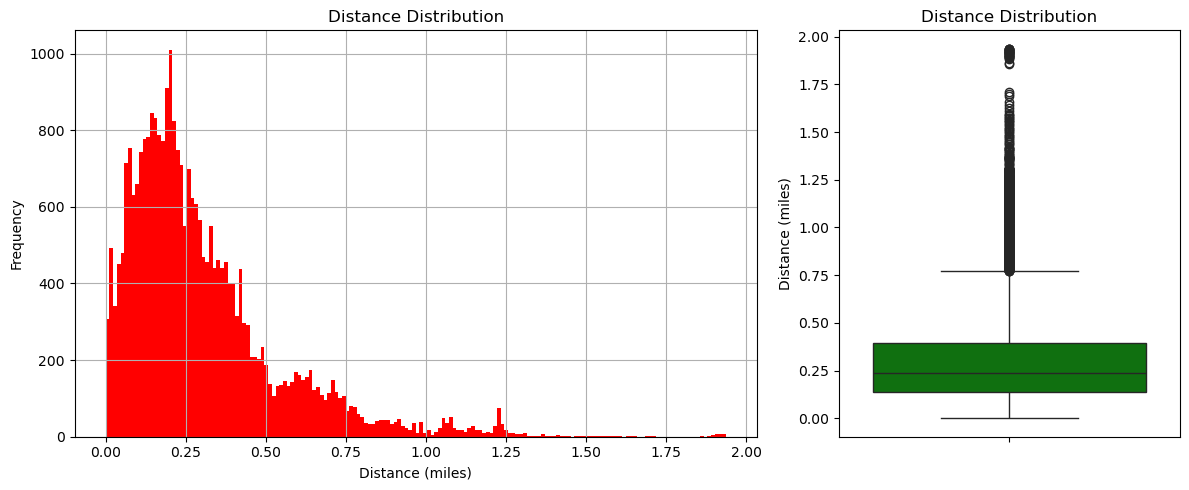

In [50]:
## Create a figure with GridSpec for custom width ratios
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 2, width_ratios=[2, 1])

# Histogram
ax1 = fig.add_subplot(gs[0])  
Cov_Metrics['Distance (miles)'].hist(bins=168, color='red', ax=ax1)
ax1.set_title('Distance Distribution')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Distance (miles)')

# Boxplot
ax2 = fig.add_subplot(gs[1])  
sns.boxplot(y=Cov_Metrics['Distance (miles)'], color='green', ax=ax2)
ax2.set_title('Distance Distribution')
ax2.set_ylabel('Distance (miles)')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.savefig('Distance_Distribution.png')
plt.show()


#### Conclusion
##### The majority of distance values are close, with some outliers ranging from over 0.75 miles to almost 2 miles. However, we will consider this the best approach. In the future, we may not need this column, as it was primarily used to strengthen the confirmation of the zone type attribution. Additionally, the date column simply represents the date when the data was collected. In the future, we will assume that all dates from different datasets fall within the same period.

In [52]:
#Removing 'Distance (miles)','Date Time' columns
Cov_Metrics = Cov_Metrics.drop(columns= ['Distance (miles)','Date Time'])

#### 2.3 Data preparation and cleaning of KPIs datasets

#####  Before Merging KPIs Dataset with Cov_Metrics, it is essential to preprocess and clean the data aswell to ensure the accuracy and reliability. The following steps shows how the KPIs dataset have been analysed

In [55]:
KPIs.head()

,Date,eNodeB Name,eNodeB Function Name,Cell Name,LocalCell Id,Cell FDD TDD Indication,Integrity,LTE_Call_Drop_Rate,LTE_CSFB_Execution_Success_Rate,LTE_CSFB_Preparation_Success_Rate,...,LTE_HO_Out_Success_Rate(Intra&Inter_freq&FddTdd),DL_PRB_Utilization(%),UL_PRB_Utilization(%),User DL PDCP Average Throughput(Mbps),User UL PDCP Average Throughput(Mbps),DL Traffic Volume (GB),UL Traffic Volume (GB),DL AVG CQI,Avg TA,Avg Pkt delay (ms)
0,01/13/2025,MBTS_C25X105_BP CONSTANTINE_MARTYRS_Acc,4C25X105,4C25X105_2,1,CELL_FDD,1.0,0.0329,100.1767,100.0000,...,99.3395,41.7810,13.7641,8.0938,2.5504,53.8353,3.9367,8.6581,509.8344,172.6663
1,01/13/2025,MBTS_C25X105_BP CONSTANTINE_MARTYRS_Acc,4C25X105,4C25X105_1,0,CELL_FDD,1.0,0.0910,99.9397,99.9398,...,99.3684,60.4635,23.5455,5.8187,2.4614,113.2049,9.8153,8.7622,424.3350,359.9596
2,01/13/2025,MBTS_C25X023_V_CITE FRERE ABESS A+_Acc,4C25X023,4C25X023_1,0,CELL_FDD,1.0,0.0386,99.7837,100.0000,...,99.6591,69.7870,27.0374,2.8401,1.9808,101.2358,10.3498,8.4795,762.9675,1090.9065
3,01/13/2025,MBTS_C25X023_V_CITE FRERE ABESS A+_Acc,4C25X023,4C25X023_2,1,CELL_FDD,1.0,0.0522,99.8755,99.8757,...,99.5333,68.7252,26.0693,3.2894,2.0212,103.6615,9.9773,7.8213,672.6073,857.7681
4,01/13/2025,MBTS_C25X023_V_CITE FRERE ABESS A+_Acc,4C25X023,4C25X023_3,2,CELL_FDD,1.0,0.0564,99.8004,99.8008,...,99.9261,27.6828,9.5529,13.1955,3.0730,45.4348,3.1923,9.4701,400.8885,81.3865


In [56]:
KPIs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84600 entries, 0 to 84599
Data columns (total 29 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Date                                                   84600 non-null  object 
 1   eNodeB Name                                            84600 non-null  object 
 2   eNodeB Function Name                                   84600 non-null  object 
 3   Cell Name                                              84600 non-null  object 
 4   LocalCell Id                                           84600 non-null  int64  
 5   Cell FDD TDD Indication                                84600 non-null  object 
 6   Integrity                                              84600 non-null  float64
 7   LTE_Call_Drop_Rate                                     83016 non-null  float64
 8   LTE_CSFB_Execution_Success_Rate               

In [57]:
KPIs.isnull().sum()

Date                                                        0
eNodeB Name                                                 0
eNodeB Function Name                                        0
Cell Name                                                   0
LocalCell Id                                                0
Cell FDD TDD Indication                                     0
Integrity                                                   0
LTE_Call_Drop_Rate                                       1584
LTE_CSFB_Execution_Success_Rate                          1588
LTE_CSFB_Preparation_Success_Rate                        1588
LTE_ERAB_Congestion_Rate                                 1578
LTE_ERAB_Setup_Success_Rate                              1578
LTE_Incoming_HHO_Success_Rate                            1584
LTE_Interfreq_Outgoing_HHO_Success_Rate                  2718
LTE_Intrafreq_Outgoing_HHO_Success_Rate                  1616
LTE_RRC_Congestion_Rate                                  1578
LTE_RRC_

##### The dataframe 'KPIs' has a total of 84600 rows and 29 columns, first columns look like they are are just Date (need to change its datatype), Site'Tower' ID and name(eNodeB means site representation in 4G) and cell Name, some features have null values need to be reviewed.

In [59]:
KPIs = KPIs.dropna()

In [60]:
#Checking NA values for each columns after cleanup
KPIs.isnull().sum()

Date                                                     0
eNodeB Name                                              0
eNodeB Function Name                                     0
Cell Name                                                0
LocalCell Id                                             0
Cell FDD TDD Indication                                  0
Integrity                                                0
LTE_Call_Drop_Rate                                       0
LTE_CSFB_Execution_Success_Rate                          0
LTE_CSFB_Preparation_Success_Rate                        0
LTE_ERAB_Congestion_Rate                                 0
LTE_ERAB_Setup_Success_Rate                              0
LTE_Incoming_HHO_Success_Rate                            0
LTE_Interfreq_Outgoing_HHO_Success_Rate                  0
LTE_Intrafreq_Outgoing_HHO_Success_Rate                  0
LTE_RRC_Congestion_Rate                                  0
LTE_RRC_Setup_Success_Rate                              

In [61]:
KPIs.nunique()

Date                                                        30
eNodeB Name                                                273
eNodeB Function Name                                       273
Cell Name                                                 2742
LocalCell Id                                                60
Cell FDD TDD Indication                                      2
Integrity                                                   15
LTE_Call_Drop_Rate                                        4190
LTE_CSFB_Execution_Success_Rate                           9242
LTE_CSFB_Preparation_Success_Rate                         6848
LTE_ERAB_Congestion_Rate                                     1
LTE_ERAB_Setup_Success_Rate                               8421
LTE_Incoming_HHO_Success_Rate                            29009
LTE_Interfreq_Outgoing_HHO_Success_Rate                  15089
LTE_Intrafreq_Outgoing_HHO_Success_Rate                  14667
LTE_RRC_Congestion_Rate                                

In [62]:
KPIs.shape[0]

81848

##### Majority of data aren't unique that need to be grouped as done for the previous dataframe, except for 'LTE_ERAB_Congestion_Rate' that contains 0 and NA values, as well as'Cell FDD TDD Indication' columns that shows type of cell if it is FDD or TDD, we'll remove these columns to avoid the risk of overfitting. 

In [64]:
display(KPIs['Cell FDD TDD Indication'].unique(),KPIs['LTE_ERAB_Congestion_Rate'].unique())


array(['CELL_FDD', 'CELL_TDD'], dtype=object)

array([0.])

In [65]:
#Removing Columns 'Cell FDD TDD Indication','LTE_ERAB_Congestion_Rate'
KPIs = KPIs.drop(columns=['Cell FDD TDD Indication','LTE_ERAB_Congestion_Rate'])

In [66]:
#Changing 'Date' datatype
KPIs['Date']= pd.to_datetime(KPIs['Date'])

In [67]:
KPIs['Date'].sample(5)

44876   2025-01-28
68026   2025-02-06
73945   2025-02-08
42007   2025-01-27
29951   2025-01-23
Name: Date, dtype: datetime64[ns]

In [68]:
KPIs.shape[1]

27

In [69]:
KPIs.columns

Index(['Date', 'eNodeB Name', 'eNodeB Function Name', 'Cell Name',
       'LocalCell Id', 'Integrity', 'LTE_Call_Drop_Rate',
       'LTE_CSFB_Execution_Success_Rate', 'LTE_CSFB_Preparation_Success_Rate',
       'LTE_ERAB_Setup_Success_Rate', 'LTE_Incoming_HHO_Success_Rate',
       'LTE_Interfreq_Outgoing_HHO_Success_Rate',
       'LTE_Intrafreq_Outgoing_HHO_Success_Rate', 'LTE_RRC_Congestion_Rate',
       'LTE_RRC_Setup_Success_Rate', 'LTE_Setup_Success_Rate',
       'LTE_HO_Incoming_Success_Rate(Intra&Inter_freq&FddTdd)',
       'LTE_HO_Out_Success_Rate(Intra&Inter_freq&FddTdd)',
       'DL_PRB_Utilization(%)', 'UL_PRB_Utilization(%)',
       'User DL PDCP Average Throughput(Mbps)',
       'User UL PDCP Average Throughput(Mbps)', 'DL Traffic Volume (GB)',
       'UL Traffic Volume (GB)', 'DL AVG CQI', 'Avg TA', 'Avg Pkt delay (ms)'],
      dtype='object')

##### The dataset contain 27 columns. The first 5 columns are date, eNodeB/ cell names and their respective IDs, then group the data by cell Names, aggregating each column using mean or median. 

In [71]:
first_list = ['Date', 'eNodeB Name', 'eNodeB Function Name','LocalCell Id']

def avg_convert(col):
    if col.name in first_list:
        return  'first'
    elif round(col.mean(), 1) == round(col.median(), 1):
        return 'mean'
    else:
        return 'median'
    

In [72]:
KPIs = KPIs.groupby('Cell Name', as_index= False).agg({
    col : avg_convert(KPIs[col]) for col in KPIs.columns if col != 'Cell Name'})

##### Above code grouped the dataframe by 'Cell Name', Aggregating other columns either by their mean or median depending of their distribution, for the IDs and name, only the first values in each group have been kept

In [74]:
KPIs.head()

,Cell Name,Date,eNodeB Name,eNodeB Function Name,LocalCell Id,Integrity,LTE_Call_Drop_Rate,LTE_CSFB_Execution_Success_Rate,LTE_CSFB_Preparation_Success_Rate,LTE_ERAB_Setup_Success_Rate,...,LTE_HO_Out_Success_Rate(Intra&Inter_freq&FddTdd),DL_PRB_Utilization(%),UL_PRB_Utilization(%),User DL PDCP Average Throughput(Mbps),User UL PDCP Average Throughput(Mbps),DL Traffic Volume (GB),UL Traffic Volume (GB),DL AVG CQI,Avg TA,Avg Pkt delay (ms)
0,4C25M365_1,2025-01-13,MBTS_C25M365,4C25M365,0,1.0,0.062340,99.963073,99.847763,99.87055,...,99.95620,27.65015,15.16175,10.83785,3.38105,48.46890,6.81215,8.72580,247.82625,112.97070
1,4C25M365_2,2025-01-13,MBTS_C25M365,4C25M365,1,1.0,0.057043,99.979870,99.969193,99.89455,...,99.83145,20.52810,14.35985,15.80520,3.00365,45.80510,5.56490,9.73510,212.29955,69.41975
2,4C25M368_1,2025-01-13,MBTS_C25M368,4C25M368,0,1.0,0.053503,99.931453,99.798447,99.90395,...,99.86535,62.42640,24.00550,3.44575,1.57645,72.47955,7.57345,7.82925,1010.11465,430.88975
3,4C25M368_2,2025-01-13,MBTS_C25M368,4C25M368,1,1.0,0.070593,99.854923,99.768370,99.80315,...,99.61720,60.55405,23.77150,3.44975,1.65460,67.28280,6.89975,7.56725,1203.57730,447.70145
4,4C25M368_4,2025-01-13,MBTS_C25M368,4C25M368,3,1.0,0.068167,99.927473,99.939833,99.91540,...,99.91065,62.01990,17.80985,3.65235,3.76305,96.72990,9.97160,8.97435,390.12325,314.91095


In [75]:
KPIs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2742 entries, 0 to 2741
Data columns (total 27 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   Cell Name                                              2742 non-null   object        
 1   Date                                                   2742 non-null   datetime64[ns]
 2   eNodeB Name                                            2742 non-null   object        
 3   eNodeB Function Name                                   2742 non-null   object        
 4   LocalCell Id                                           2742 non-null   int64         
 5   Integrity                                              2742 non-null   float64       
 6   LTE_Call_Drop_Rate                                     2742 non-null   float64       
 7   LTE_CSFB_Execution_Success_Rate                        2742 non-null 

In [76]:
KPIs.nunique()

Cell Name                                                2742
Date                                                        9
eNodeB Name                                               273
eNodeB Function Name                                      273
LocalCell Id                                               60
Integrity                                                  21
LTE_Call_Drop_Rate                                       2655
LTE_CSFB_Execution_Success_Rate                          2684
LTE_CSFB_Preparation_Success_Rate                        2687
LTE_ERAB_Setup_Success_Rate                              2290
LTE_Incoming_HHO_Success_Rate                            2665
LTE_Interfreq_Outgoing_HHO_Success_Rate                  2179
LTE_Intrafreq_Outgoing_HHO_Success_Rate                  2485
LTE_RRC_Congestion_Rate                                   308
LTE_RRC_Setup_Success_Rate                               2674
LTE_Setup_Success_Rate                                   2428
LTE_HO_I

In [77]:
#Removing columns Dates and Integrity
KPIs = KPIs.drop(columns=['Date','Integrity'])

In [78]:
KPIs.shape

(2742, 25)

##### Final KPIs  dataframe shows a well structured dataset with 2742 entries, 27 columns with their adequate data type and with no missing values. The Date and integretiy columns have been removed since we assumed that all the date have been collected at the same time, the integreity column has only 21 unique values which might lead to high variance within KPIs dataset.

#### 2.4 Data preparation and cleaning of EPT dataset

##### The EPT dataset contains information about eNodeB towers, including their locations and identifiers. Cleaning and structuring this dataset is also indispensable before merging it with the KPIs and Cov_Metrics datasets for comprehensive analysis.

In [82]:
EPT.head()

,Cell Name,NE Name,eNodeB Id,Local cell identity,Longitude,Latitude,Azimuth,HBA,E-T,M-T,...,Cell FDD TDD indication,RSI,Cell radius,MCC,MNC,TAC,RS Power,PA,Pb,TXRX Mode
0,4O02X001_1,MBTS_O02X001,402001,0,1.3395,36.16583,60,15,80.0,0.0,...,CELL_FDD,72.0,10000,603,2,20201.0,182.0,NaN,1.0,2T2R
1,4O02X001_2,MBTS_O02X001,402001,1,1.3395,36.16583,180,15,20.0,0.0,...,CELL_FDD,256.0,10000,603,2,20201.0,182.0,NaN,1.0,2T2R
2,4O02X001_3,MBTS_O02X001,402001,2,1.3395,36.16583,330,15,60.0,0.0,...,CELL_FDD,168.0,10000,603,2,20201.0,182.0,NaN,1.0,2T2R
3,4O02X001_10,MBTS_O02X001,402001,9,1.3395,36.16583,250,15,80.0,0.0,...,CELL_FDD,424.0,10000,603,2,20201.0,182.0,NaN,1.0,2T2R
4,4O02X002_1,MBTS_O02X002,402002,0,1.51236,36.13658,100,16,20.0,0.0,...,CELL_FDD,488.0,10000,603,2,20204.0,182.0,NaN,1.0,1T2R


In [83]:
EPT.shape

(46488, 29)

In [84]:
EPT.columns

Index(['Cell Name', 'NE Name', 'eNodeB Id', 'Local cell identity', 'Longitude',
       'Latitude', 'Azimuth', 'HBA', 'E-T', 'M-T', 'Commune', 'Antenna Type',
       'Antenna Gain (dBi)', 'Wilaya (Region)', 'Frequency band',
       'Downlink EARFCN', 'Cell ID', 'PCI', 'Cell active state',
       'Cell FDD TDD indication', 'RSI', 'Cell radius', 'MCC', 'MNC', 'TAC',
       'RS Power', 'PA', 'Pb', 'TXRX Mode'],
      dtype='object')

In [85]:
KPIs.columns

Index(['Cell Name', 'eNodeB Name', 'eNodeB Function Name', 'LocalCell Id',
       'LTE_Call_Drop_Rate', 'LTE_CSFB_Execution_Success_Rate',
       'LTE_CSFB_Preparation_Success_Rate', 'LTE_ERAB_Setup_Success_Rate',
       'LTE_Incoming_HHO_Success_Rate',
       'LTE_Interfreq_Outgoing_HHO_Success_Rate',
       'LTE_Intrafreq_Outgoing_HHO_Success_Rate', 'LTE_RRC_Congestion_Rate',
       'LTE_RRC_Setup_Success_Rate', 'LTE_Setup_Success_Rate',
       'LTE_HO_Incoming_Success_Rate(Intra&Inter_freq&FddTdd)',
       'LTE_HO_Out_Success_Rate(Intra&Inter_freq&FddTdd)',
       'DL_PRB_Utilization(%)', 'UL_PRB_Utilization(%)',
       'User DL PDCP Average Throughput(Mbps)',
       'User UL PDCP Average Throughput(Mbps)', 'DL Traffic Volume (GB)',
       'UL Traffic Volume (GB)', 'DL AVG CQI', 'Avg TA', 'Avg Pkt delay (ms)'],
      dtype='object')

##### The EPT dataset consists of 29 columns and  46488 rows. The first columns, such as 'Cell Name', 'NE Name' and  'Local cell identity' are nearly identical to those to  the KPIs dataset. In order to merge these datasets, we will first group them by these commonncolumns. However, before preoceeding we mush check for duplicate rows in the EPT dataset to ensure data integrity.

In [87]:
EPT.duplicated(subset=['Cell Name', 'NE Name', 'Local cell identity']).sum()

1030

In [88]:
EPT = EPT.drop_duplicates(subset = ['Cell Name', 'NE Name', 'Local cell identity'])

In [89]:
EPT.shape

(45458, 29)

In [90]:
EPT.duplicated(subset=['Cell Name', 'NE Name', 'Local cell identity']).sum()

0

In [91]:
KPIs = KPIs.rename(columns={'eNodeB Name': 'NE Name', 'LocalCell Id': 'Local cell identity'})

In [92]:
Data = pd.merge( EPT, KPIs, 
             on= ['Cell Name', 'NE Name', 'Local cell identity'] )

##### The number of rows generated should be the same or less  as the number of KPIs dataframe rows since we removed before all duplicated values, EPT dataframe must have some duplicated rows that need to be checked

In [94]:
len(Data) <= len(KPIs)

True

In [95]:
Data.duplicated(subset=['Cell Name', 'NE Name', 'Local cell identity']).sum()

0

In [96]:
#Check number of rows generated after merging
Data.shape

(2739, 51)

In [97]:
Data.nunique()

Cell Name                                                2739
NE Name                                                   272
eNodeB Id                                                 272
Local cell identity                                        60
Longitude                                                 354
Latitude                                                  353
Azimuth                                                    70
HBA                                                       137
E-T                                                        22
M-T                                                         1
Commune                                                    26
Antenna Type                                               15
Antenna Gain (dBi)                                          6
Wilaya (Region)                                             2
Frequency band                                              4
Downlink EARFCN                                             5
Cell ID 

##### The columns 'M-T'(Mechanical tilt), 'Cell radius', 'MCC', 'MNC'contain only a single unique value, providing no useful variation, so they will be removed. In addition, NE Name','eNodeB Function Name' and 'eNodeB Id' serve as identifiers and are highly similar, so we will retain only one of them. The same applies to 'Local cell identity' and 'Cell ID'and 'cellName'.
##### Furthermore, many KPI features have unique values in the majority of rows, making them unsuitable for machine learning models due to their lacj of predictive power.

In [99]:
Data = Data.drop(columns=['M-T', 'Cell radius', 'MCC', 'MNC','Cell ID', 'NE Name','eNodeB Function Name','Local cell identity','Cell ID'])

In [100]:
#Checking null values contained for each column
Data.isnull().sum()

Cell Name                                                   0
eNodeB Id                                                   0
Longitude                                                   0
Latitude                                                    0
Azimuth                                                     0
HBA                                                         0
E-T                                                       888
Commune                                                   119
Antenna Type                                                0
Antenna Gain (dBi)                                          0
Wilaya (Region)                                           188
Frequency band                                              0
Downlink EARFCN                                             0
PCI                                                         0
Cell active state                                           0
Cell FDD TDD indication                                     0
RSI     

##### The columns 'E-T'(elictrical Tilt), 'Commune', 'Wilaya (Region)', 'RS Power', 'PA' and 'Pb' contain null values. The 'Commune', 'Wilaya (Region)' columns will be removed since they only serve as regional identifiers. Also, 'PA' will be dropped as it has 2728 null values out of 2739. 
##### However, despite the siginificant number of missing values in if 'RS Power','Pb' and 'E-T', Power and tilt-related features have been used in previous research for LTE coverage prediction, so they will be retained for further analysis.

In [102]:
Data = Data.drop(columns=[ 'Commune', 'Wilaya (Region)','PA'])

In [103]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2739 entries, 0 to 2738
Data columns (total 40 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cell Name                                              2739 non-null   object 
 1   eNodeB Id                                              2739 non-null   int64  
 2   Longitude                                              2739 non-null   object 
 3   Latitude                                               2739 non-null   object 
 4   Azimuth                                                2739 non-null   object 
 5   HBA                                                    2739 non-null   object 
 6   E-T                                                    1851 non-null   float64
 7   Antenna Type                                           2739 non-null   object 
 8   Antenna Gain (dBi)                              

In [104]:
display(Data['Cell active state'].unique(),
       Data['Cell FDD TDD indication'].unique())

array(['CELL_ACTIVE', 'CELL_DEACTIVE'], dtype=object)

array(['CELL_FDD', 'CELL_TDD'], dtype=object)

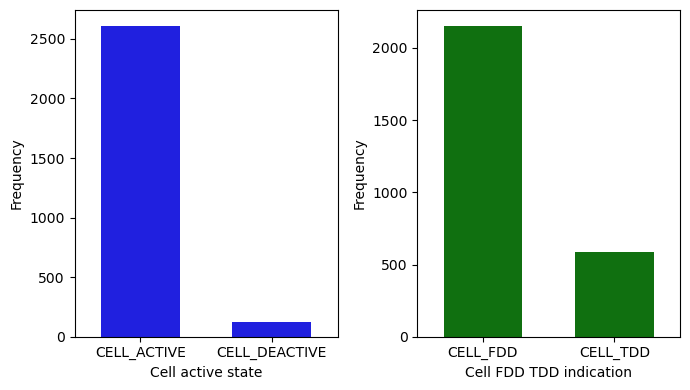

In [105]:
fig = plt.figure(figsize=(7, 4))

value1 = Data['Cell active state'].value_counts().sort_index()
plt.subplot(1,2,1)
sns.barplot(x = value1.index , y = value1.values, color= 'blue',width=0.6 )
#plt.title('Cell active state Distribution')
plt.ylabel('Frequency')


value2 = Data['Cell FDD TDD indication'].value_counts().sort_index()
plt.subplot(1,2,2)
sns.barplot(x = value2.index , y = value2.values, color= 'green',width=0.6 )
#plt.title('Cell FDD TDD indication Distribution')
plt.ylabel('Frequency')


plt.tight_layout()
plt.savefig('Cell_active_state_distribution.png')
plt.show()

In [106]:
Data[Data['Cell active state'] == 'CELL_DEACTIVE'].shape[0]

127

###### Reference 4 : Sauter, M. (2011). From GSM to LTE: An Introduction to Mobile Networks and Mobile Broadband. Wiley..

##### The 'Cell active state' and 'Cell FDD TDD indication' columns each contain two unique categorical values, making them imbalanced. This can be problematic during the training of machine learning models, as the imbalance may affect the model's ability to learn effectively(possiblity of overfitting).

##### The 'Cell activate state' indicates whether the cell is operational or not, if the cell is deativated it will not provide the necessary coverage . The 'Cell FDD TDD indication' column shows the type of duplex transmission mode( FDD or TDD), unlike the 'Cell active state' tha can directly impact coverage, this feature does impact more likely network performance.

##### The total number of deactivated cells is 127. These cells will removed, as we assume they were inactive during the measurements taken for the radio metrics( RSRP, RSRQ and SINR) collected in the drive test, then, 'Cell active state' column will be removed since it will only contain only a unique value 'Cell Active' . We will reomve the 'Cell FDD TDD indication' column, as it is not essential for analysis.

In [108]:
Data =Data.drop(columns=['Cell FDD TDD indication'])

In [109]:
Data = Data[Data['Cell active state'] != 'CELL_DEACTIVE']

In [110]:
Data =Data.drop(columns=['Cell active state'])

In [111]:
Data.isnull().sum()

Cell Name                                                  0
eNodeB Id                                                  0
Longitude                                                  0
Latitude                                                   0
Azimuth                                                    0
HBA                                                        0
E-T                                                      767
Antenna Type                                               0
Antenna Gain (dBi)                                         0
Frequency band                                             0
Downlink EARFCN                                            0
PCI                                                        0
RSI                                                        0
TAC                                                        0
RS Power                                                 231
Pb                                                       243
TXRX Mode               

##### The remaining missing values in these columns are important and need to be filled, as removing them would lead to a significant loss of data(at least 767 rows). To handle this effectively, we will first analyse the distribution of unique values in the concerned columns to better undedrstand their characteristics.

In [113]:
 Data['E-T'].unique()

array([5.5000e+01, 3.2767e+04, 4.0000e+01, 2.0000e+01, 5.0000e+01,
       3.5000e+01,        nan, 6.0000e+01, 7.0000e+01, 8.0000e+01,
       1.0000e+02, 0.0000e+00, 3.0000e+01, 7.5000e+01, 9.0000e+01,
       4.5000e+01, 1.0000e+01, 8.5000e+01, 9.5000e+01, 5.0000e+00,
       1.5000e+01, 1.2000e+02, 6.5000e+01])

In [114]:
Data['RS Power'].unique()

array([182., 190., 212.,  43., 152., 157., 145., 133., 165., 151., 164.,
       142.,  90.,  nan])

In [115]:
Data['Pb'].unique()

array([ 1.,  0.,  3., nan])

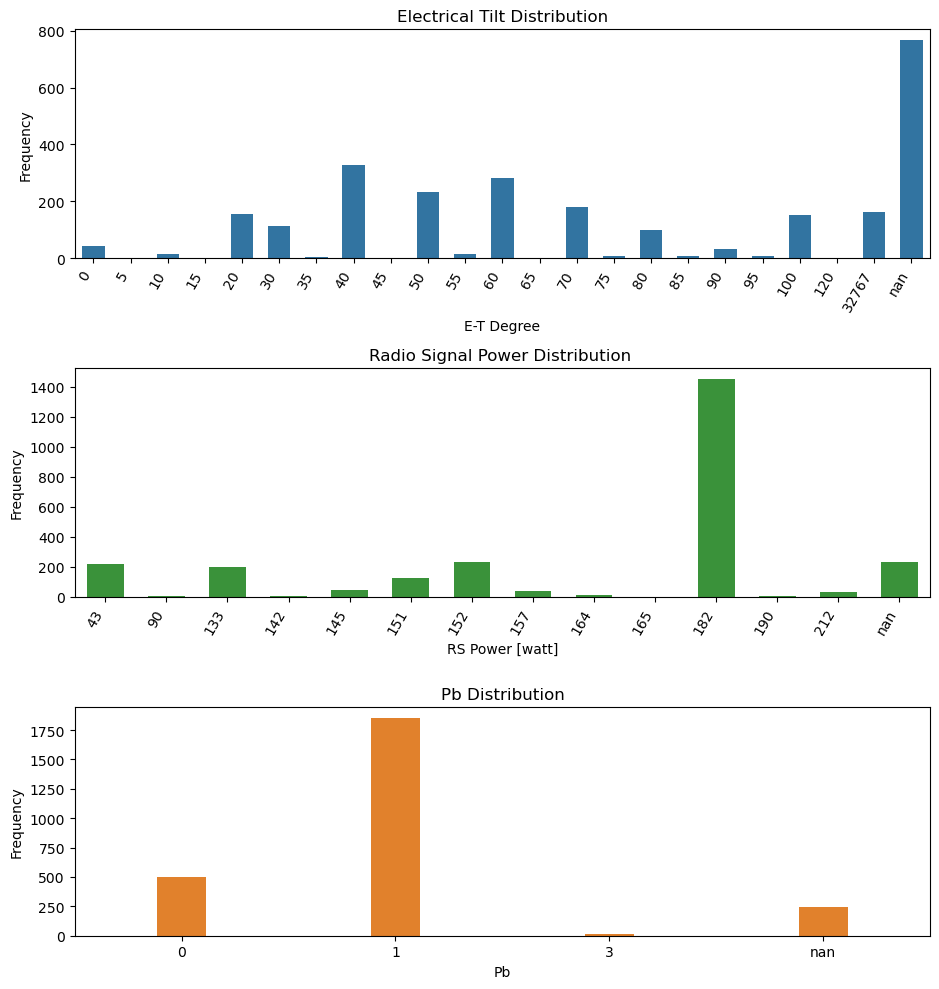

In [116]:
value1 = Data['E-T'].value_counts(dropna= False).sort_index()
value3 = Data['Pb'].value_counts(dropna= False).sort_index()
value2 = Data['RS Power'].value_counts(dropna= False).sort_index()

fig = plt.figure(figsize=(9.5, 10))

plt.subplot(3,1,1)
x1 = [str(int(x)) if x == float(x) else str(x) for x in value1.index]
sns.barplot(x = x1 , y = value1.values, color= '#1f77b4',width=0.6 )
plt.title('Electrical Tilt Distribution')
plt.xlabel('E-T Degree')
plt.ylabel('Frequency')
plt.xticks(rotation=60, ha='right')


plt.subplot(3,1,2)
x2 = [str(int(x)) if x == float(x) else str(x) for x in value2.index]
sns.barplot(x = x2 , y = value2.values, color= '#2ca02c',width=0.6 )
plt.title('Radio Signal Power Distribution ')
plt.xlabel('RS Power [watt]')
plt.ylabel('Frequency')
plt.xticks(rotation=60, ha='right')


plt.subplot(3,1,3)
x3 = [str(int(x)) if x == float(x) else str(x) for x in value3.index]
sns.barplot(x = x3 , y = value3.values, color= '#ff7f0e',width=0.23 )
plt.title('Pb Distribution')
plt.xlabel('Pb')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('E-T_RS_Powere_Pb_Distribution.png')
plt.show()

##### The bar charts show the distributions of  'E-T', 'RS Power', 'Pb' values in the Data dataset.
##### 'E-T Distribution' has a large spread interval with peaks in 40 and 60 degress and outlier at  32767 degres, which must be an error. There's a massive presence of missing values.
##### 'Radio Signal Power Distribution' has an interval between [43,212] watt with a peak at 182 watt, including some missing values.
##### 'Pb Distribution' is highly imbalanced, mostly 1, then 0 and with just a few cases of 3. It has also missing values


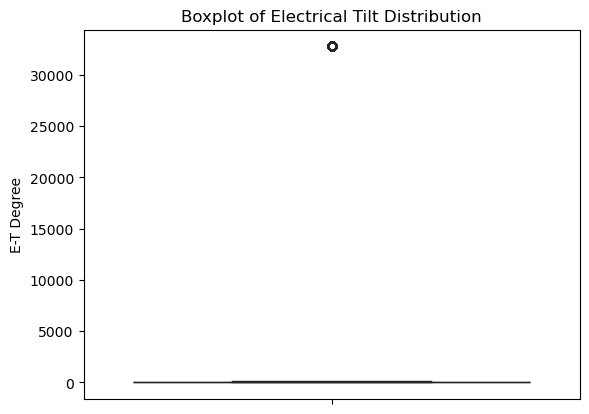

In [118]:
sns.boxplot(y=Data['E-T'], color='green')
plt.title('Boxplot of Electrical Tilt Distribution')
plt.ylabel('E-T Degree')
plt.savefig('Boxplot_E-T_distribution.png')
plt.show()

In [119]:
display(Data['E-T'].describe(),
       Data['RS Power'].describe(),
       Data['Pb'].describe())

count     1845.000000
mean      2926.197290
std       9260.726061
min          0.000000
25%         40.000000
50%         60.000000
75%         80.000000
max      32767.000000
Name: E-T, dtype: float64

count    2381.000000
mean      159.284754
std        41.071167
min        43.000000
25%       151.000000
50%       182.000000
75%       182.000000
max       212.000000
Name: RS Power, dtype: float64

count    2369.000000
mean        0.797805
std         0.437933
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: Pb, dtype: float64

##### The 'E-T'column has a very high standard deviation compared to its mean, indicating a wide spread of values and confirming the existance of the  outlier as shown in above by a boxplot. To enmsure a stable distribution , we will change this outliers  with the median value. proceding the same for all missing values in 'E-T', 'RS Power', 'Pb' using their respective median values.

In [121]:
Data.loc[Data['E-T']== 32767, 'E-T'] = Data['E-T'].median()

In [122]:
Data['E-T'].describe()

count    1845.000000
mean       54.363144
std        23.242762
min         0.000000
25%        40.000000
50%        60.000000
75%        70.000000
max       120.000000
Name: E-T, dtype: float64

In [123]:
#Replacing missing values with their median
cols = ['E-T','RS Power','Pb']
Data[cols] = Data[cols].apply(lambda col: col.fillna(col.median()))

In [124]:
#Checking if there still any missing values withihn those columns
Data[cols].isnull().sum()

E-T         0
RS Power    0
Pb          0
dtype: int64

In [125]:
#Checking if Data still has null values
Data.isnull().sum()

Cell Name                                                0
eNodeB Id                                                0
Longitude                                                0
Latitude                                                 0
Azimuth                                                  0
HBA                                                      0
E-T                                                      0
Antenna Type                                             0
Antenna Gain (dBi)                                       0
Frequency band                                           0
Downlink EARFCN                                          0
PCI                                                      0
RSI                                                      0
TAC                                                      0
RS Power                                                 0
Pb                                                       0
TXRX Mode                                               

##### Now the KPIs and EPT datasets have been merged and cleaned, the next step is to  merge them with the Cov_Metrics dataset.This will create the final dataset, allowing the most relevant features for predicting the target metrics( RSRP, SINR, RSRQ) by analysing correlations and dependencies. 

In [127]:
Data.head()

,Cell Name,eNodeB Id,Longitude,Latitude,Azimuth,HBA,E-T,Antenna Type,Antenna Gain (dBi),Frequency band,...,LTE_HO_Out_Success_Rate(Intra&Inter_freq&FddTdd),DL_PRB_Utilization(%),UL_PRB_Utilization(%),User DL PDCP Average Throughput(Mbps),User UL PDCP Average Throughput(Mbps),DL Traffic Volume (GB),UL Traffic Volume (GB),DL AVG CQI,Avg TA,Avg Pkt delay (ms)
0,4C25X001_1,425001,6.6211,36.2864,180,27,55.0,HW_ATR4517R0_1800_17dBi_H65_06_T,17.0,3,...,99.19600,23.9734,10.25875,14.94930,3.25080,28.38250,3.36880,9.70745,1371.03945,89.39295
1,4C25X001_2,425001,6.6211,36.2864,330,27,55.0,HW_ATR4517R0_1800_17dBi_H65_06_T,17.0,3,...,99.53170,61.5452,24.25070,4.85635,2.28185,91.36010,9.91365,8.37885,2244.92145,251.67425
2,4C25X001_3,425001,6.6211,36.2864,250,27,60.0,HW_ATR4517R0_1800_17dBi_H65_06_T,17.0,3,...,99.14515,48.0378,15.46895,5.00735,2.52605,49.31015,5.02220,7.35470,1899.20800,210.55990
3,4C25X001_4,425001,6.6211,36.2864,180,27,40.0,HW_ATR4517R0_1800_17dBi_H65_06_T,17.0,1,...,98.20450,51.1361,27.63000,9.85675,2.30305,124.82870,16.59610,10.53510,2345.62835,122.29970
4,4C25X001_5,425001,6.6211,36.2864,330,27,40.0,HW_ATR4517R0_1800_17dBi_H65_06_T,17.0,1,...,99.38600,26.1694,11.88980,16.48190,2.49870,51.26245,4.28900,9.90120,738.67860,70.98240


In [128]:
Cov_Metrics.head()

,Latitude,Longitude,Serving Cell RSRP (dBm),Serving Cell RSRQ (dB),Serving Cell RS SINR (dB),Zone_Type
0,36.258200,6.611071,-104.599998,-11.7,4.3,Suburban
1,36.258217,6.610993,-102.699997,-11.2,7.5,Suburban
2,36.258233,6.611145,-105.599998,-11.8,3.6,Suburban
3,36.258272,6.610954,-105.199997,-11.7,3.9,Suburban
4,36.258286,6.611167,-104.699997,-13.2,-1.4,Suburban


###### Reference 5: Holma, H. and Toskala, A. (2017) LTE Advanced: 3GPP Solution for IMT-Advanced. Wiley.


##### After examining abive the columns in both 'Data' and 'Cov_Metrics' datasets, the goal is to merge them by calculating the distances between each location in both datasets(between cell location and the measured points of radio signal metrics). For each row in 'Data', all columns from 'Cov_Metrics' will be assigned based on the nearest location. Assuming that the mobile user always connects to the closest cell.[5]


In [130]:
Data[['Latitude', 'Longitude']] = Data[['Latitude', 'Longitude']].astype(float)


In [131]:

def calculate_bearing(lat1, lon1, lat2, lon2):
    """Calculate bearing from point1 to point2 in degrees"""
    return Geodesic.WGS84.Inverse(lat1, lon1, lat2, lon2)['azi1']

# Prepare coordinates
Data_coords = np.radians(Data[['Latitude', 'Longitude']])
Cov_coords = np.radians(Cov_Metrics[['Latitude', 'Longitude']])

# Find 5 nearest candidates for each sector
tree = BallTree(Cov_coords, metric='haversine')
distances, indices = tree.query(Data_coords, k=5)

# Process matches with azimuth alignment
rsrp_values = []
sinr_values = []
rsrq_values = []
zone_types = []
distances_miles = []

for i in range(len(Data)):
    tower_lat = Data.iloc[i]['Latitude']
    tower_lon = Data.iloc[i]['Longitude']
    tower_azimuth = Data.iloc[i]['Azimuth']
    
    candidates = Cov_Metrics.iloc[indices[i]]
    bearings = [calculate_bearing(tower_lat, tower_lon, clat, clon) 
                for clat, clon in zip(candidates['Latitude'], candidates['Longitude'])]
    
    # Calculate angular differences
    angle_diffs = np.abs(np.array(bearings) - tower_azimuth)
    angle_diffs = np.minimum(angle_diffs, 360 - angle_diffs)
    
    # Combine distance and angle (50/50 weight)
    norm_dist = distances[i] / np.max(distances[i])
    norm_angle = angle_diffs / 180
    combined_scores = 0.5 * norm_dist + 0.5 * norm_angle
    
    best_idx = np.argmin(combined_scores)
    
    # Store best match
    best = candidates.iloc[best_idx]
    rsrp_values.append(best['Serving Cell RSRP (dBm)'])
    sinr_values.append(best['Serving Cell RS SINR (dB)'])
    rsrq_values.append(best['Serving Cell RSRQ (dB)'])
    zone_types.append(best['Zone_Type'])
    distances_miles.append(distances[i][best_idx] * 3958.8)

# Update DataFrame
Data['Serving Cell RSRP (dBm)'] = rsrp_values
Data['Serving Cell RS SINR (dB)'] = sinr_values
Data['Serving Cell RSRQ (dB)'] = rsrq_values
Data['Zone_Type'] = zone_types
Data['Distance (miles)'] = distances_miles

In [132]:
Data.head()

,Cell Name,eNodeB Id,Longitude,Latitude,Azimuth,HBA,E-T,Antenna Type,Antenna Gain (dBi),Frequency band,...,DL Traffic Volume (GB),UL Traffic Volume (GB),DL AVG CQI,Avg TA,Avg Pkt delay (ms),Serving Cell RSRP (dBm),Serving Cell RS SINR (dB),Serving Cell RSRQ (dB),Zone_Type,Distance (miles)
0,4C25X001_1,425001,6.6211,36.2864,180,27,55.0,HW_ATR4517R0_1800_17dBi_H65_06_T,17.0,3,...,28.38250,3.36880,9.70745,1371.03945,89.39295,-73.099998,12.3,-9.8,Suburban,0.014610
1,4C25X001_2,425001,6.6211,36.2864,330,27,55.0,HW_ATR4517R0_1800_17dBi_H65_06_T,17.0,3,...,91.36010,9.91365,8.37885,2244.92145,251.67425,-80.300003,10.4,-10.1,Suburban,0.024271
2,4C25X001_3,425001,6.6211,36.2864,250,27,60.0,HW_ATR4517R0_1800_17dBi_H65_06_T,17.0,3,...,49.31015,5.02220,7.35470,1899.20800,210.55990,-80.300003,10.4,-10.1,Suburban,0.024271
3,4C25X001_4,425001,6.6211,36.2864,180,27,40.0,HW_ATR4517R0_1800_17dBi_H65_06_T,17.0,1,...,124.82870,16.59610,10.53510,2345.62835,122.29970,-73.099998,12.3,-9.8,Suburban,0.014610
4,4C25X001_5,425001,6.6211,36.2864,330,27,40.0,HW_ATR4517R0_1800_17dBi_H65_06_T,17.0,1,...,51.26245,4.28900,9.90120,738.67860,70.98240,-80.300003,10.4,-10.1,Suburban,0.024271


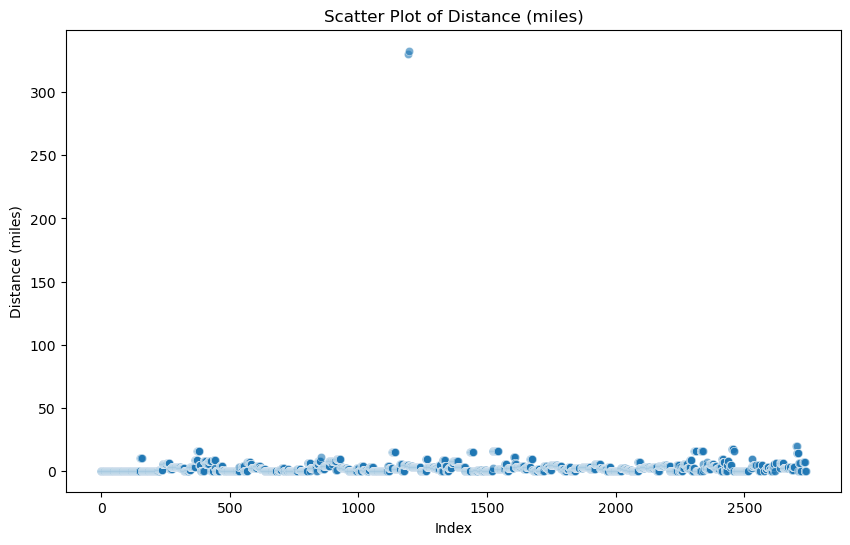

In [133]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=Data.index, y=Data['Distance (miles)'], color='#1f77b4', alpha=0.6)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Distance (miles)')
plt.title('Scatter Plot of Distance (miles)')
plt.savefig('scatter_plot_distance.png')
# Show plot
plt.show()

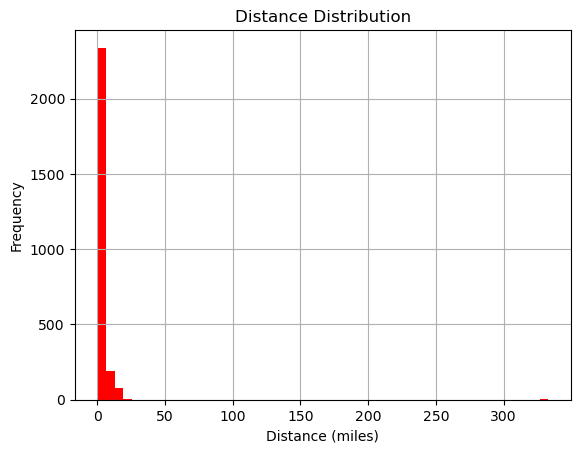

In [134]:
Data['Distance (miles)'].hist(bins=52, color='red')
plt.xlabel('Distance (miles)')
plt.ylabel('Frequency')
plt.title('Distance Distribution')
plt.savefig('histogram_plot_distance.png')
plt.show()

In [135]:
Data['Distance (miles)'].describe()

count    2612.000000
mean        2.753310
std         9.690612
min         0.001417
25%         0.034258
50%         1.463928
75%         3.411503
max       332.951189
Name: Distance (miles), dtype: float64

In [136]:
#Checking for missing values
Data['Distance (miles)'].isnull().sum()

0

##### Reference 6 : https://dgtlinfra.com/cell-tower-range-how-far-reach/

#### The maximum theoritical range is 62 miles. However, in real-world scenarios, the is much shorter due to factors such as weather conditions, interference, terrrain and user equipment (UE) capabilities. On average, the coverage range based on the environment type:

#### In Rural areas, it ranges from 3.1 to 18.6 miles; in suburban areas, it falls between 1.2 and 3.1 miles; while for Uraban areas, the coverage range is limited to 1.2 miles maximum.


#### Based on the graphs displayed above, the majority values in the 'Distance (miles)' columns are below 20 miles, with a mean of 2.75 miles, which appears realistic. However, the maximum value is around 332 miles, which is unrealistic, even if we compared it with the theoretical maximum distance. Therefore, the data requires cleaning by excluding rows with distances that exceed the maximum practical value of 18.6 miles.

In [138]:
#Checking how many rows are having that exceed the practical distance average
(Data['Distance (miles)']>18.6).sum()

4

In [139]:
Data = Data.drop(Data[Data['Distance (miles)'] > 18.6].index)

In [140]:
(Data['Distance (miles)']>18.6).sum()

0

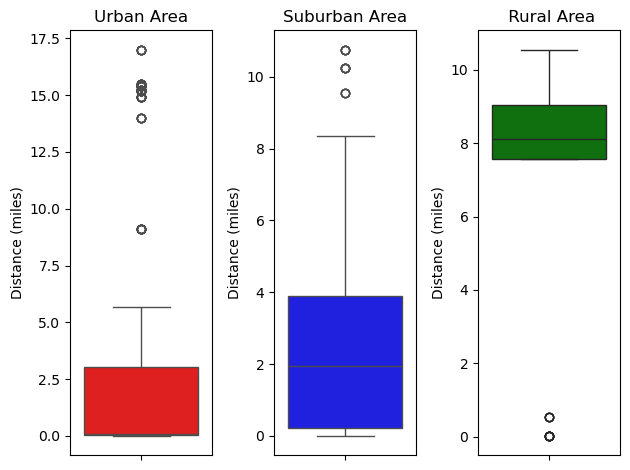

In [141]:
#plt.figure(figsize=(3.5,12))
plt.subplot(1,3,1)
urban_data = Data[Data['Zone_Type'] == 'Urban']
sns.boxplot(y=urban_data['Distance (miles)'], color='red')
plt.ylabel('Distance (miles)')
plt.title('Urban Area')

plt.subplot(1,3,2)
suburban_data = Data[Data['Zone_Type'] == 'Suburban']
sns.boxplot(y=suburban_data['Distance (miles)'], color='blue')
#plt.ylabel('Distance (miles)')
plt.title('Suburban Area')

plt.subplot(1,3,3)
rural_data = Data[Data['Zone_Type'] == 'Rural']
sns.boxplot(y=rural_data['Distance (miles)'], color='green')
#plt.ylabel('Distance (miles)')
plt.title(' Rural Area')

plt.tight_layout()
plt.savefig('Zone_Type_Distribution.png')
plt.show()

In [142]:
Data[Data['Zone_Type'] == 'Urban']['Distance (miles)'].describe()

count    1181.000000
mean        2.232434
std         3.949692
min         0.001417
25%         0.027139
50%         0.082769
75%         3.030490
max        17.006316
Name: Distance (miles), dtype: float64

In [143]:
Data[Data['Zone_Type'] == 'Suburban']['Distance (miles)'].describe()

count    1366.000000
mean        2.517521
std         2.411421
min         0.002744
25%         0.226544
50%         1.937588
75%         3.896359
max        10.756223
Name: Distance (miles), dtype: float64

In [144]:
Data[Data['Zone_Type'] == 'Rural']['Distance (miles)'].describe()

count    61.000000
mean      6.794963
std       3.357704
min       0.024145
25%       7.561308
50%       8.127942
75%       9.037960
max      10.552219
Name: Distance (miles), dtype: float64

##### The boxplots and descriptive statistics reveal distinct distance patterns between UE and eNodeB across geographic areas:
##### Urban Areas: The median distance is less than 1 mile, but the distribution exhibit hish skewness (mean~2.23) due to extreme outilier reaching up to 17 miles.
##### Suburban Areas: The distance show moderate dispersion, with an interquartile between 0.22 and 3.89. This alligns almost perfectly with real world expectations.
##### Rural Areas: Most distances range between 7 and 9 miles, with a maximum recorded value of 10.5 miles, which remains within realistic limit in that geographical area.

##### Overall, all distances from different zone type are below the global theoritical maximum (18.6 miles). However, Urban and Suburban areas contain values exceeding their environment specific practical limits. Those outliers need to be removed.

In [146]:
((Data['Distance (miles)'] >1.2) & (Data['Zone_Type']== 'Urban')).sum()

479

In [147]:
((Data['Distance (miles)'] >3.1) & (Data['Zone_Type']== 'Suburban')).sum()

402

##### Showing values the top 25% of the data( the highest values)  that exceed the average  distance  between UE and eNodeB by Zone Type(Urban and Rural)

In [149]:
((Data['Distance (miles)']> Data['Distance (miles)'].quantile(0.75)) & (Data['Zone_Type']== 'Urban')).sum()

219

In [150]:
((Data['Distance (miles)']> Data['Distance (miles)'].quantile(0.75)) & (Data['Zone_Type']== 'Suburban')).sum()

378

##### The number of data points exceeding environmental thresholds(Urban <1.2 mile, Suburban < 3.1 miles) is significant, we could preserve more data by removing all values beyoond IQ3. However, for greater accuracy and alignment with real-world scenarios, we will remove all outlier that dont adhere to practical coverage limits.

In [152]:
Data = Data.drop(Data[((Data['Distance (miles)'] >1.2) & (Data['Zone_Type']== 'Urban'))].index)

In [153]:
Data = Data.drop(Data[((Data['Distance (miles)'] >3.1) & (Data['Zone_Type']== 'Suburban'))].index)

In [154]:
((Data['Distance (miles)'] >1.2) & (Data['Zone_Type']== 'Urban')).sum()

0

In [155]:
((Data['Distance (miles)'] >3.1) & (Data['Zone_Type']== 'Suburban')).sum()

0

In [156]:
len(Data)

1727

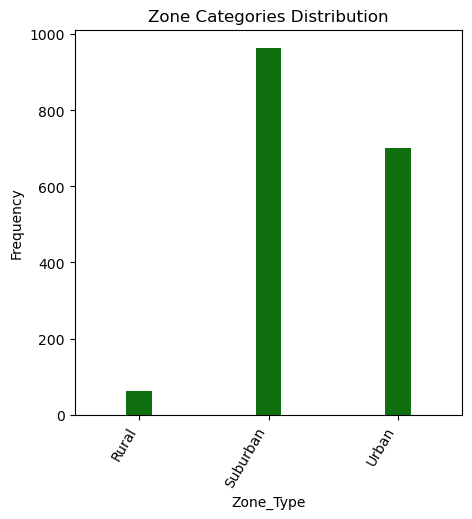

In [157]:
value4 = Data['Zone_Type'].value_counts().sort_index()

fig = plt.figure(figsize=(5, 5))

sns.barplot(x = value4.index , y = value4.values, color= 'green',width=0.2 )

plt.title('Zone Categories Distribution')
plt.ylabel('Frequency')
plt.xticks(rotation=60, ha='right')
plt.savefig('Zone_categories_Distribution_2.png')
plt.show()

##### The dataset is imbalanced in terms of Zone_Type, with only a small number of rural area entries. To maintain consistency, we will focus on the other areas by removing all rows corresponding to rural area.

In [159]:
Data= Data.drop(Data[Data['Zone_Type']== 'Rural'].index)

##### Some frequency bandsare used in specific areas, such as band 8 (900 MHz) in rural regions, while band 40, 3 and 1( 2.3 , 1.8 and 2.1 GHz) are mainly deployed in urban/ Suburban areas. However, these freuqencies may also be used  added in different zones  due to high load demand (congestion), even if some bands don't support long distances

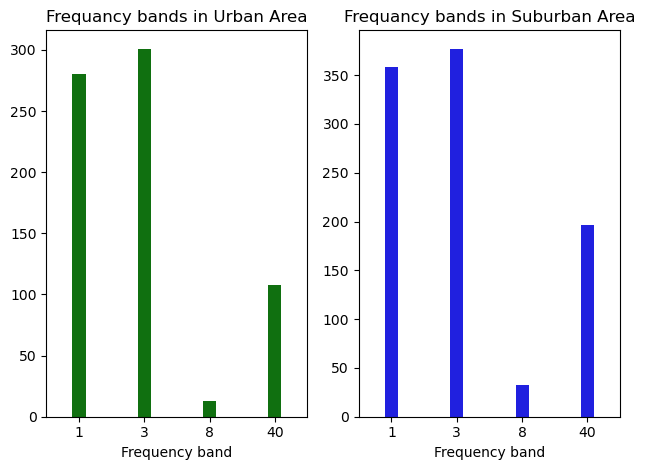

In [161]:

Urban_Data = Data[Data['Zone_Type'] == 'Urban']
Suburban_Data = Data[Data['Zone_Type'] == 'Suburban']

plt.subplot(1,2,1)
value4 = Urban_Data['Frequency band'].value_counts().sort_index()
sns.barplot(x = value4.index , y = value4.values, color= 'green',width=0.2 )
plt.title('Frequancy bands in Urban Area')


plt.subplot(1,2,2)
value5 = Suburban_Data['Frequency band'].value_counts().sort_index()
sns.barplot(x = value5.index , y = value5.values, color= 'blue',width=0.2 )
plt.title('Frequancy bands in Suburban Area')


plt.tight_layout()
plt.savefig('frequency bands dsitribution_2.png')
plt.show()

##### In both Areas, it shows that the band 8 is underrepresented compared to the other frequencies, keep it could negatively impact the performance of the model (imbalanced data)

In [163]:
Data= Data.drop(Data[Data['Frequency band']== 8].index)

##### Cleanup at column level

##### All the provided datasets have now been merged and cleaned from missing values and noise at the row level. The next step is to perform column-level cleanup ny selecting the most relevant features for predicting radio signal metrics(RSRP, RSRQ and SINR).

##### The cleanup process will be based on using a combination of domain knowledge, correlation analysis, and feature importance techniques
##### First, all features that are known from their definitions and previous research to have an impact on coverage prediction will be retained, even their correlation with the target variable is low.Second, we will keep all features that show significant correlation with the radio signal metrics. Additionally, in case where two features are highly correlated  with each other and both not meet the previous conditions will be removed, if they they are correlated with the target variable, only one of them will be removed to avoid multicolinearity and reduce overfitting. Preference will be given to the a stronger correlation with the target. Finally, feature selection will be refined using feature importance techniques, specifically, Random Forest Importance. to retain the most relevant predictors.

##### 1 - Remove all identifiers:
##### Columns like 'Cell Name' and 'eNodeB ID' will be removed whihc they served only as a labels IDs to merge between datasets.
##### 'PCI' Physical Cell Identity, is a unique identifier assigned to each LTE cell used for synchronisation purposes.
##### 'RSI' Root Sequence Index, is a signal identifier used for synchronisation puposes.
##### 'TAC' Tracking Area Code, a logical groupiing of LTE cells that helps in tracking UE location at a large area level (has no direct imact in radio signal quality)

In [167]:
Data = Data.drop(columns=['Cell Name', 'eNodeB Id', 'TAC','PCI','RSI','Longitude', 'Latitude'])

In [168]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1620 entries, 0 to 2738
Data columns (total 36 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Azimuth                                                1620 non-null   object 
 1   HBA                                                    1620 non-null   object 
 2   E-T                                                    1620 non-null   float64
 3   Antenna Type                                           1620 non-null   object 
 4   Antenna Gain (dBi)                                     1620 non-null   float64
 5   Frequency band                                         1620 non-null   int64  
 6   Downlink EARFCN                                        1620 non-null   int64  
 7   RS Power                                               1620 non-null   float64
 8   Pb                                                   

##### Some feature data types need to be adjusted before performing the correlation analysis. Specifically, the columns 'Azimuth' and 'HBA' contain numerical values but are stored as object types. Additionally, the categorical columns 'TXRX Mode', 'Zone_Type' and 'Antenna Type' will eb transformed using one-hot encoding to enable their inclusion in the correlation analysis with target variables.

In [170]:
#Changing the data type to float
Data['Azimuth'] = Data['Azimuth'].astype(float)
Data['HBA'] = Data['HBA'].astype(float)

In [171]:
#one-hot encoding to 'TXRX Mode', 'Zone_Type','Antenna Type' columns
Data1 = pd.get_dummies(Data, columns=['TXRX Mode', 'Zone_Type','Antenna Type'], drop_first=False)

###### Reference 7: Sauter, M. (2021). From GSM to LTE-Advanced Pro and 5G: An Introduction to Mobile Networks and Mobile Broadband (4th ed.). Chichester: Wiley.
###### Reference 8: Zhang, X. (2018) LTE optimization engineering handbook. Hoboken, NJ: John Wiley & Sons Singapore Pte. Ltd.

##### LTE_Call_Drop_Rate, LTE_CSFB_Execution_Success_Rate, LTE_CSFB_Preparation_Success_Rate, LTE_ERAB_Setup_Success_Rate, LTE_Incoming_HHO_Success_Rate, LTE_Interfreq_Outgoing_HHO_Success_Rate, LTE_Intrafreq_Outgoing_HHO_Success_Rate, LTE_RRC_Congestion_Rate, LTE_RRC_Setup_Success_Rate, LTE_Setup_Success_Rate, LTE_HO_Incoming_Success_Rate(Intra&Inter_freq&FddTdd), LTE_HO_Out_Success_Rate(Intra&Inter_freq&FddTdd)
##### These represent Key performance indicators related to  Network performance, They are often outcomes of radio coverage and quality, rather than predictors that affect sognal propagation, if these KPIs show no significant correlation with the target variables, they will be removed

In [173]:
# Change the positions of predictors to the end for better visualisation during correlation analysis
Data1.insert(49, 'Serving Cell RSRP (dBm)', Data1.pop('Serving Cell RSRP (dBm)'))
Data1.insert(49, 'Serving Cell RS SINR (dB)', Data1.pop('Serving Cell RS SINR (dB)'))
Data1.insert(49, 'Serving Cell RSRQ (dB)', Data1.pop('Serving Cell RSRQ (dB)'))

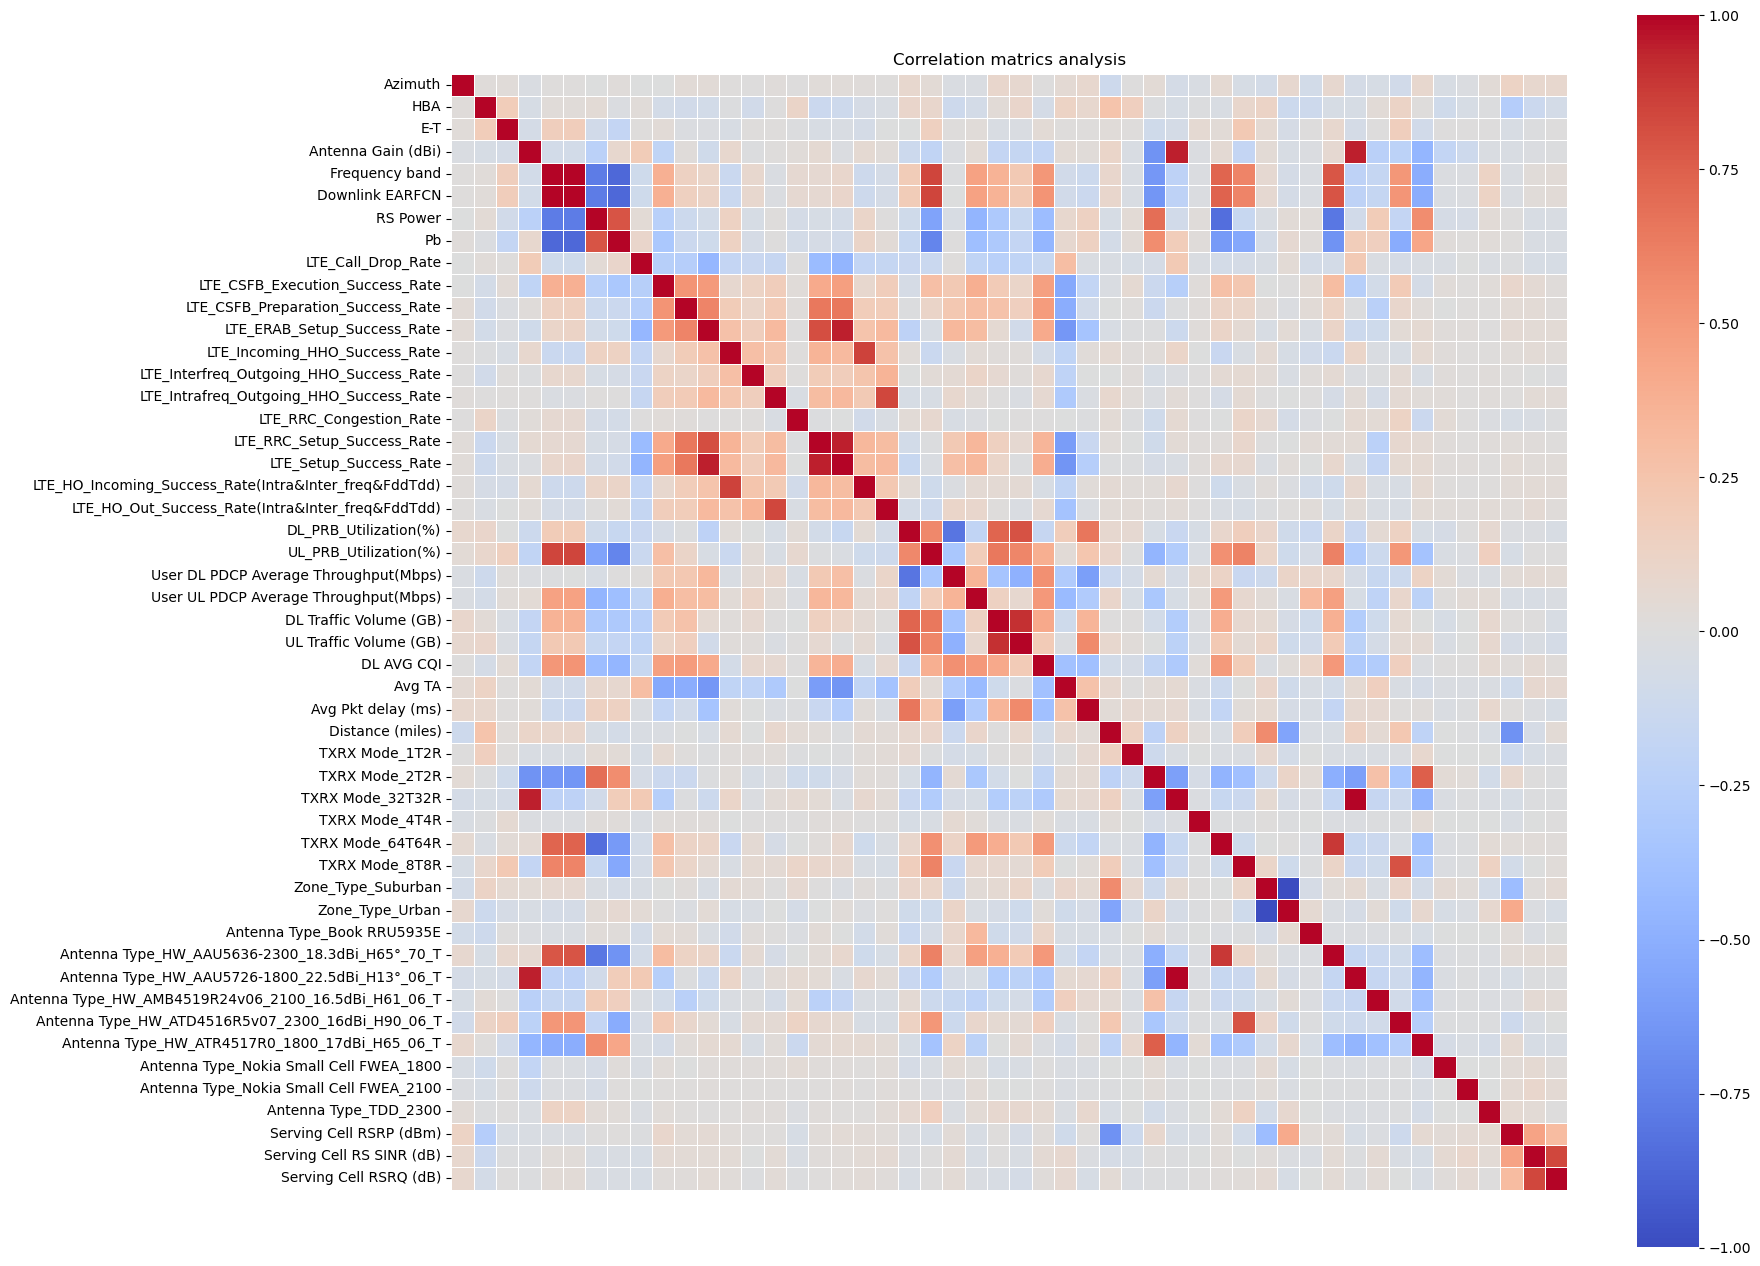

In [174]:
corr_matrix = Data1.corr()

plt.figure(figsize=(18, 16))
sns.heatmap(corr_matrix, 
            cmap="coolwarm",
            linewidths=0.5,
             fmt=".2f",
           square= True
           )
plt.xticks([],[])
plt.title('Correlation matrics analysis')
plt.savefig('Correlation matrics.png', dpi =300)
plt.show()


##### There is no significant correlation observed between most input variables and the target variables (RSRP,RSRQ and SINR), except  for a clear negative correlation between the distance from the user equipment (UE) to the serving cell and the RSRP value. This negative correlation is expected, as the further the user moves away from the cell tower, the weaker the received signal strength bcomes(Sesia et al., 2011). Additionally, a moderate correlation is noted between the zone type and RSRP( a negative correlation with suburban area and positive with urban), as well as a weak correlation with the tower hight (HBA) and azimuth. But , these correlation remain relatively low.

##### Furthermore, although a correlation exists between the target variable and the geographical coordinates (longitude and latitude) if bith the user and the cell tower, this correlation is not informative for the prediction model. These coordinates merley represent location information, and hteir effect is already captured by the distance feature. Therefore, latitude and longitude will be excluded from the feature set. (Holma & Toskala, 2011).
##### All network performance KPIs mentioned previously-including PRB utilisation, User DL/UL PDCP Average Throughput(Mbps), DL/UL Traffic Volume (GB),and Avg Pkt delay (ms), show almost null correlation with the target variables. These metrics are influenced by coverage quality but do not directly impact physical coverage or signal strength itself. As such, they will be removed(Dahlman et al., 2014).

##### The average downlink CQI (channel Quality Indicator) is conceptually a reflection of RSRP and SINR values since it indicates channel quality perceived by the user. However, the correlation matrix does not reveal strong statistical redundancy with SINR. Similarly, Average Timing Advance (TA) values exhibit an expected tren: higher TA correlates with lower RSRP/SINR. Nevertheless, this correlation is weak, and theur inclusion as predictors will be evaluated using random Forest feature importance analysis(Aliu et al., 2012).

##### TxRx modes and antenna type  demonstarte internal correlations related to antenna configuration and capabilities. Additionally, a strong correlation exists between the 'Frequency Band' and ' Downlink EARFCN', which is logical as the EARFCN directly corresponds to the central frequency of the band and does not vary (Holma & Toskala, 2011). A strong negative correlation is also observed between 'Pb' parameter and both  'Frequency Band' and ' Downlink EARFCN'. as well as, a strong positive correlation between 'Pb' and 'Radio Signal Power' (RS Power). Since RS Power has been identified in previous research as an important factor in LTE coverage prediction, only this feature will be retained whille 'Pb' will be excluded to avoid redundancy (Sesia et al., 2011).


##### Lastly, Most antenna-related parameters, such as antenna gain, transmit power, frquency and Tx/Rx mode, also show high intercorrelation, reflecting their dependence on the specific characteristics and configuration of each antenna model(Dahlman et al., 2014).


In [176]:
Data.columns

Index(['Azimuth', 'HBA', 'E-T', 'Antenna Type', 'Antenna Gain (dBi)',
       'Frequency band', 'Downlink EARFCN', 'RS Power', 'Pb', 'TXRX Mode',
       'LTE_Call_Drop_Rate', 'LTE_CSFB_Execution_Success_Rate',
       'LTE_CSFB_Preparation_Success_Rate', 'LTE_ERAB_Setup_Success_Rate',
       'LTE_Incoming_HHO_Success_Rate',
       'LTE_Interfreq_Outgoing_HHO_Success_Rate',
       'LTE_Intrafreq_Outgoing_HHO_Success_Rate', 'LTE_RRC_Congestion_Rate',
       'LTE_RRC_Setup_Success_Rate', 'LTE_Setup_Success_Rate',
       'LTE_HO_Incoming_Success_Rate(Intra&Inter_freq&FddTdd)',
       'LTE_HO_Out_Success_Rate(Intra&Inter_freq&FddTdd)',
       'DL_PRB_Utilization(%)', 'UL_PRB_Utilization(%)',
       'User DL PDCP Average Throughput(Mbps)',
       'User UL PDCP Average Throughput(Mbps)', 'DL Traffic Volume (GB)',
       'UL Traffic Volume (GB)', 'DL AVG CQI', 'Avg TA', 'Avg Pkt delay (ms)',
       'Serving Cell RSRP (dBm)', 'Serving Cell RS SINR (dB)',
       'Serving Cell RSRQ (dB)', 'Zone_Typ

In [177]:
Data = Data.drop(columns = [ 'Downlink EARFCN', 'Pb', 'LTE_Call_Drop_Rate', 'LTE_CSFB_Execution_Success_Rate',
       'LTE_CSFB_Preparation_Success_Rate', 'LTE_ERAB_Setup_Success_Rate',
       'LTE_Incoming_HHO_Success_Rate',
       'LTE_Interfreq_Outgoing_HHO_Success_Rate',
       'LTE_Intrafreq_Outgoing_HHO_Success_Rate', 'LTE_RRC_Congestion_Rate',
       'LTE_RRC_Setup_Success_Rate', 'LTE_Setup_Success_Rate',
       'LTE_HO_Incoming_Success_Rate(Intra&Inter_freq&FddTdd)',
       'LTE_HO_Out_Success_Rate(Intra&Inter_freq&FddTdd)',
       'DL_PRB_Utilization(%)', 'UL_PRB_Utilization(%)',
       'User DL PDCP Average Throughput(Mbps)',
       'User UL PDCP Average Throughput(Mbps)', 'DL Traffic Volume (GB)',
       'UL Traffic Volume (GB)', 'Avg Pkt delay (ms)',
                            'TXRX Mode','Antenna Type',])

In [178]:
Data.shape[1]

13

In [179]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1620 entries, 0 to 2738
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Azimuth                    1620 non-null   float64
 1   HBA                        1620 non-null   float64
 2   E-T                        1620 non-null   float64
 3   Antenna Gain (dBi)         1620 non-null   float64
 4   Frequency band             1620 non-null   int64  
 5   RS Power                   1620 non-null   float64
 6   DL AVG CQI                 1620 non-null   float64
 7   Avg TA                     1620 non-null   float64
 8   Serving Cell RSRP (dBm)    1620 non-null   float64
 9   Serving Cell RS SINR (dB)  1620 non-null   float64
 10  Serving Cell RSRQ (dB)     1620 non-null   float64
 11  Zone_Type                  1620 non-null   object 
 12  Distance (miles)           1620 non-null   float64
dtypes: float64(11), int64(1), object(1)
memory usage: 177

#### Random Forest Feature selection

In [181]:
Data = pd.get_dummies(Data, columns=['Zone_Type'], drop_first=False)

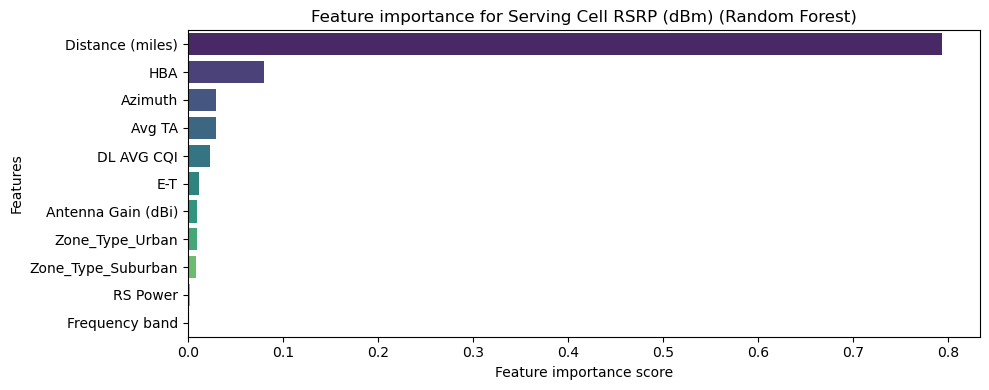

Feature importance for Serving Cell RSRP (dBm) (Random Forest)
               Feature  Importance
8     Distance (miles)    0.793597
1                  HBA    0.079787
0              Azimuth    0.030106
7               Avg TA    0.029479
6           DL AVG CQI    0.023627
2                  E-T    0.011841
3   Antenna Gain (dBi)    0.009998
10     Zone_Type_Urban    0.009470
9   Zone_Type_Suburban    0.008377
5             RS Power    0.002741
4       Frequency band    0.000977


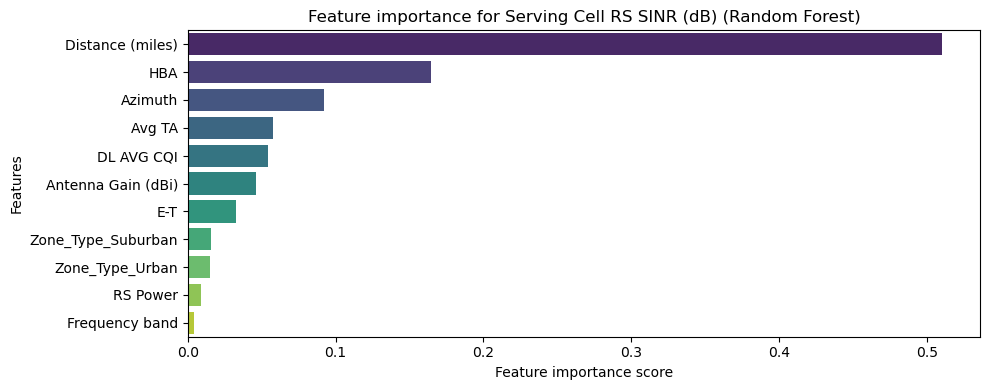

Feature importance for Serving Cell RS SINR (dB) (Random Forest)
               Feature  Importance
8     Distance (miles)    0.510411
1                  HBA    0.164369
0              Azimuth    0.092026
7               Avg TA    0.057740
6           DL AVG CQI    0.054036
3   Antenna Gain (dBi)    0.045877
2                  E-T    0.032368
9   Zone_Type_Suburban    0.015478
10     Zone_Type_Urban    0.015003
5             RS Power    0.008765
4       Frequency band    0.003928


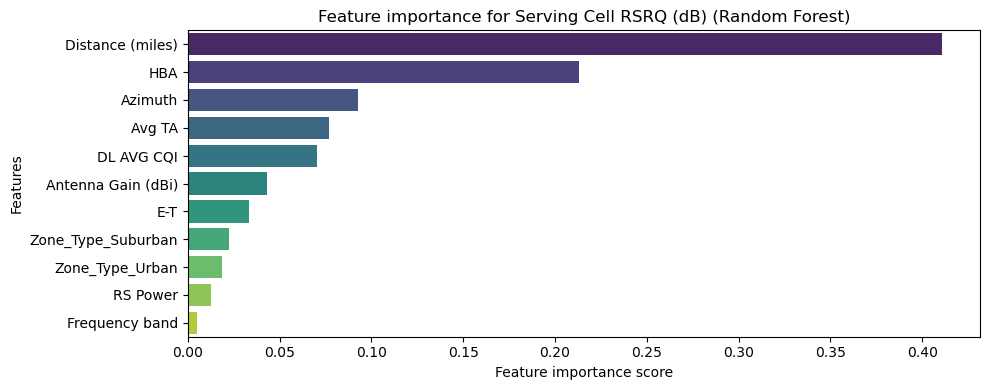

Feature importance for Serving Cell RSRQ (dB) (Random Forest)
               Feature  Importance
8     Distance (miles)    0.410874
1                  HBA    0.213165
0              Azimuth    0.092879
7               Avg TA    0.076831
6           DL AVG CQI    0.070548
3   Antenna Gain (dBi)    0.043126
2                  E-T    0.033576
9   Zone_Type_Suburban    0.022393
10     Zone_Type_Urban    0.018903
5             RS Power    0.012732
4       Frequency band    0.004973


In [182]:

warnings.filterwarnings('ignore')

targets = ['Serving Cell RSRP (dBm)','Serving Cell RS SINR (dB)','Serving Cell RSRQ (dB)']
for target in targets:
    x = Data.drop(columns = targets)
    y = Data[target]
    
    model = RandomForestRegressor(n_estimators= 100, random_state= 42)
    model.fit(x,y)
    
    importance = pd.DataFrame({
        'Feature': x.columns,
        'Importance': model.feature_importances_
    }).sort_values(by = 'Importance', ascending = False)
    plt.figure(figsize= (10,4))
    sns.barplot(x= 'Importance', 
                y= 'Feature',
                data = importance,
                palette = 'viridis'
               )
    
    plt.xlabel('Feature importance score')
    plt.ylabel('Features')
    plt.title(f'Feature importance for {target} (Random Forest)')
    
    plt.tight_layout()
    plt.show()

    print(f'Feature importance for {target} (Random Forest)')
    print(importance)

In [183]:
# Change the positions of predictors to the end for better visualisation during correlation analysis
Data.insert(13, 'Serving Cell RSRP (dBm)', Data.pop('Serving Cell RSRP (dBm)'))
Data.insert(13, 'Serving Cell RS SINR (dB)', Data.pop('Serving Cell RS SINR (dB)'))
Data.insert(13, 'Serving Cell RSRQ (dB)', Data.pop('Serving Cell RSRQ (dB)'))

In [184]:
# Rename target columns
Data.rename(columns= {
    'Serving Cell RSRP (dBm)': 'RSRP (dBm)',
    'Serving Cell RS SINR (dB)': 'SINR (dB)',
    'Serving Cell RSRQ (dB)' : 'RSRQ (dB)'
}, inplace = True)


In [185]:
#Final adjustement round specific columns
Data[['Antenna Gain (dBi)', 'RS Power', 'DL AVG CQI','Avg TA','Distance (miles)','RSRP (dBm)','SINR (dB)','RSRQ (dB)']] = Data[['Antenna Gain (dBi)', 'RS Power', 'DL AVG CQI','Avg TA','Distance (miles)','RSRP (dBm)','SINR (dB)','RSRQ (dB)']].round(2)

In [186]:
Data.head()

,Azimuth,HBA,E-T,Antenna Gain (dBi),Frequency band,RS Power,DL AVG CQI,Avg TA,Distance (miles),Zone_Type_Suburban,Zone_Type_Urban,RSRP (dBm),SINR (dB),RSRQ (dB)
0,180.0,27.0,55.0,17.0,3,182.0,9.71,1371.04,0.01,True,False,-73.1,12.3,-9.8
1,330.0,27.0,55.0,17.0,3,182.0,8.38,2244.92,0.02,True,False,-80.3,10.4,-10.1
2,250.0,27.0,60.0,17.0,3,190.0,7.35,1899.21,0.02,True,False,-80.3,10.4,-10.1
3,180.0,27.0,40.0,17.0,1,182.0,10.54,2345.63,0.01,True,False,-73.1,12.3,-9.8
4,330.0,27.0,40.0,17.0,1,182.0,9.90,738.68,0.02,True,False,-80.3,10.4,-10.1


#### Feature Importance analysis

##### Feature importance for RSRP Target variable:
##### Thenfeature analysis indicated that Distance contributes approximately 79% of the overall importance in predicting RSRP. This aligns well with radio propagation theory, confirming that signal strength is influenced by the distance from the transmitter. The second most significant feature is the Height of Base Antenna (HBA), contributing around 8%, highlighting the impact of antenna elevation on coverage quality. The remaining features, such as Avg TA, DL AVG CQI , Azimuth, and others, contribute marginally, with importance scores ranging between 0.001% and 3%

##### Feature importance for SINR Target variable:
##### For SINR prediction, Distance remains the most influential feature, contributing 51% to yhe model. This is followed again by HBA with an importance score of 16%, and 9.2% for Azimuth. Other features such as  features such as 'Avg TA' and 'CQI' have moderate contribution of 5.5% both. RS Power and Frequency bandare the least important features in the model.


##### Feature importance for RSRQ Target variable:
##### The feature importance analysis for RSRQ also shows Distance as the most dominant predictor, with an importance score of 41%. it is followed again by HBA at 21%. Additional features such as 'Azimuth', 'Avg TA' and  'CQI' also contribute meaningully with 9.2%, 7.7% and 7%, respectively.



#### Conclusion

##### In summary, the feature importance analysis using the Random Forest model and feature target correlation values both confirm that 'Distance' is the most dominant factor influencing all three target variables (RSRP, RSRQ and SINR). it is consistently followed by 'HBA' ,'Azimuth', 'Avg TA' and  'CQI' and . On the other hand, 'RS Power' and 'Frequency Band' show very low importance scores. However, prior ressearch (Holma & Toskala, 2011; Dahlman et al., 2014) suggests these parameters may still influence signal behaviour and radio performance inspecific scenarios. Including these features could provide additional insights but risks introducing noise due to their weak predictive power in this dataset.


##### A sensitive analysis will be conducted alongside testing alternative machine learning algorithms. These models will be trained on the refined dataset, with hyperparameter tuning applied to optimise performance and reduce the impact of irrelevant features.

In [191]:
Data.to_csv('Data.csv', index = False)

In [192]:
Data.shape

(1620, 14)